# Прогнозирование спроса товаров собственного производства


### Описание задачи

Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.
 

### Описание данных

1. **sales_df_train.csv** –данные по продажам за скользящий год для обучения.

     * *st_id* – захэшированное id магазина;
     * *pr_sku_id* – захэшированное id товара;
     * *date* – дата;
     * *pr_sales_type_id* – флаг наличия промо;
     * *pr_sales_in_units* – число проданных товаров без признака промо;
     * *pr_promo_sales_in_units* – число проданных товаров с признаком промо;
     * *pr_sales_in_rub* – продажи без признака промо в РУБ;
     * *pr_promo_sales_in_rub* – продажи с признаком промо в РУБ;


2. **pr_df.csv** – данные по товарной иерархии.

    * *pr_group_id* – захэшированная группа товара;
    * *pr_cat_id* – захэшированная категория товара;
    * *pr_subcat_id* – захэшированная подкатегория товара;
    * *pr_sku_id* – захэшированное id товара;
    * *pr_uom_id* (маркер, обозначающий продаётся товар на вес или в ШТ).
    
    
    
3. **pr_st.csv** – данные по магазинам.

    * *st_id* – захэшированное id магазина;
    * *st_city_id* – захэшированное id города;
    * *st_division_code id* – захэшированное id дивизиона;
    * *st_type_format_id* – id формата магазина;
    * *st_type_loc_id* – id тип локации/окружения магазина;
    * *st_type_size_id* – id типа размера магазина;
    * *st_is_active* – флаг активного магазина на данный момент.



## Первичное ознакомление с данными

In [1]:
# Установка необходимых библиотек
!pip install statsmodels
!pip install catboost
!pip install lightgbm
!pip install xgboost 
!pip install --upgrade tables
!pip install blosc2~=2.0.0
!pip install pmdarima
!pip install phik==0.10.0
!pip install calmap


  Obtaining dependency information for blosc2>=2.3.0 from https://files.pythonhosted.org/packages/9c/24/68e19daabf0601452ae236b31f54d21b3796180b7d7f1a9d4cb6d8f1a649/blosc2-2.4.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
    --------------------------------------- 0.0/2.3 MB 330.3 kB/s eta 0:00:07
    --------------------------------------- 0.0/2.3 MB 326.8 kB/s eta 0:00:08
   - -------------------------------------- 0.1/2.3 MB 393.8 kB/s eta 0:00:06
   - -------------------------------------- 0.1/2.3 MB 504.4 kB/s eta 0:00:05
   -- ------------------------------------- 0.2/2.3 MB 612.6 kB/s eta 0:00:04
   ---- ----------------------------------- 0.3/2.3 MB 827.5 kB/s eta 0:00:03
   ------ --------------------------------- 0.4/2.3 MB 1.1 MB/s eta 0:00:02
   -------- ------------------------------- 0.5/2.3 MB 1.3 MB/s eta 0:00:02
   ------------ -------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.9.2 requires blosc2>=2.3.0, but you have blosc2 2.0.0 which is incompatible.


In [2]:
# Импорт библиотек
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import phik
import calmap
import pickle
import calendar
import statsmodels.api as sm
import gc

from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from phik.report import plot_correlation_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

In [3]:
#Функция для анализа продаж по неделям в течении одного месяца
def analyze_month(df, month_name):
    pd.set_option('display.max_colwidth', 100)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index(['date'])

    # Группируем по store_id, pr_sku_id и неделе, подсчитываем сумму pr_sales_in_units и pr_sales_in_rub
    weekly_sales = df.groupby(['st_id', 'pr_sku_id', pd.Grouper(freq='W')])[['pr_sales_in_units', 'pr_sales_in_rub']].sum()

    # Сбрасываем индексы
    weekly_sales = weekly_sales.reset_index()

    print(f"Месяц: {month_name}")
    print('*'*100)
    
    # Топ-5 товаров за месяц для всех магазинов
    print("\nТоп-5 товаров за месяц:")
    top_5_items_all_stores = df.groupby('pr_sku_id')['pr_sales_in_units'].sum().nlargest(5)
    print(top_5_items_all_stores)
    print('*'*100)

    # Количество проданных товаров за каждую неделю
    print("Продажи в штуках по неделям:")
    weekly_total_sales = weekly_sales.groupby('date')['pr_sales_in_units'].sum()
    print(weekly_total_sales)
    print('*'*100)

    # Сумма продаж за каждую неделю
    print("Сумма продаж по неделям:")
    weekly_total_sales_rub = weekly_sales.groupby('date')['pr_sales_in_rub'].sum().round(2)
    print(weekly_total_sales_rub)

    # Для каждого магазина
    for store_id, store_data in weekly_sales.groupby('st_id'):
        print('*'*100)
        print(f"\nМагазин ID: {store_id}")
        print()
        
        # Город магазина
        print("Город магазина:")
        store_city = df[df['st_id'] == store_id]['st_city_id'].iloc[0]
        print(store_city)
        
        # Сумма продаж за месяц для каждого магазина
        print("Сумма продаж за месяц:")
        store_total_sales_rub = store_data['pr_sales_in_rub'].sum().round(2)
        print(store_total_sales_rub)
        print()
        
        # Сумма продаж за неделю для каждого магазина
        print("Сумма продаж по неделям:")
        store_weekly_sales_rub = store_data.groupby('date')['pr_sales_in_rub'].sum().round(2)
        print(store_weekly_sales_rub)
        print()

        # Топ-10 товаров по продажам для каждой недели
        print("Топ-10 товаров по продажам по неделям:")
        top_10_items_by_week = store_data.groupby('date').apply(
            lambda x: ', '.join(map(str, x.nlargest(10, 'pr_sales_in_units')['pr_sku_id'].tolist()))
        )
        print(top_10_items_by_week)

        # Топ-5 товаров по продажам за весь месяц
        print()
        print("Топ-5 товаров по продажам за весь месяц:")
        top_5_items_month = store_data.nlargest(5, 'pr_sales_in_units')[['pr_sku_id', 'pr_sales_in_units', 'pr_sales_in_rub']]
        top_5_items_month['pr_sales_in_rub'] = top_5_items_month['pr_sales_in_rub'].round(2)
        print(top_5_items_month)



In [4]:
# Построение графика изменения продаж товаров в штуках с рампределением по месяцам
def plot_cat_sales(data, name,  date, column1, column2, column3):
    
    df = data[data[column1] == name][[date, column2, column3]]
    df[date] = pd.to_datetime(df[date])
    df.set_index(date, inplace=True)
    pivot_table = df.pivot_table(index=df.index.month, columns=column2, values=column3, aggfunc='sum')

    plt.figure(figsize=(15, 5))
    
    sns.lineplot(data=pivot_table)
    plt.legend(loc='upper left')
    plt.xlabel('Месяц')
    plt.ylabel('Количество товара')
    plt.title(f'Изменение продаж товаров {name} группы по категориям по месяцам')
    plt.show()
    
    
# Установка даты в качестве индекса для создаваемых срезов таблицы при анализе
def set_date_index(input_df, col_name='date'):
    
    modified_df = input_df.copy()
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])
    modified_df.set_index(col_name, inplace=True)

    return modified_df    


# Подсчет строк с отрицательными значениями в столбце
def neg_val(data, column):
    count = len(data[data[column] < 0])
    
    return count

# Расчет WAPE по скользящему среднему
def rolling_wape(y_true, y_pred):
    rolling_wape = np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
    return rolling_wape


# Функция для получения предсказаний и подготовки результатов к пролучению предсказаний мета-модели
def predict_model_1st_level(df, all_models, column):
    
    df = generate_features(df)

    features_df = df.drop([column], axis=1)
    target_df_col_1 = df[column]

    
    meta_feat = []
    for model in all_models:
        y_pred = model.predict(features_df)
        meta_feat.append(y_pred)
        
    meta_feat_array = np.array(meta_feat, dtype=np.float32).T.reshape(-1, len(meta_feat))
    target_valid_array = target_df_col_1.values.astype(np.float32).reshape(-1, 1)
       
    return meta_feat_array, target_valid_array, features_df, target_df_col_1

# Построение графиков остаточного анализа
def residual_plot(df):
    # Вычисление остатков
    residuals = df['prediction'] - df['target']

    # Стандартизация остатков
    standardized_residuals = ((residuals - residuals.mean()) / residuals.std()).astype(np.float32)

    residuals = residuals.astype(np.float32)

    # Создание графиков 2x2
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))

    ax[0, 0].plot(residuals)
    ax[0, 0].axhline(residuals.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(standardized_residuals, title='Correlogram', ax=ax[0, 1])

    sm.qqplot(residuals, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(residuals.min(), residuals.max(), 1000)
    norm = stats.norm(loc=0, scale=residuals.std())
    ax[1, 1].hist(residuals, bins=30, label='histogram', density=True)
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

Загрузим исходные данные и выведем первичную информацию о данных. 

In [5]:
data_dir = 'C:/Users/tra88/Downloads/Лента/sp_sales_task'
try:
    df_train = os.path.join(data_dir, 'sales_df_train.csv')
    train = pd.read_csv(df_train)
    
    df_pr = os.path.join(data_dir, 'pr_df.csv')
    pr = pd.read_csv(df_pr)
    
    df_st_df = os.path.join(data_dir, 'st_df.csv')
    st_df = pd.read_csv(df_st_df)
    
    df_holiday = os.path.join(data_dir, 'holidays_covid_calendar.csv')
    holiday = pd.read_csv(df_holiday)
    
except:
    train = pd.read_csv('sales_df_train.csv')
    pr = pd.read_csv('pr_df.csv')
    st_df = pd.read_csv('st_df.csv')
    holiday = pd.read_csv('holidays_covid_calendar.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [7]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [8]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes


В датафрейме train присутствует столбец date, содержащий дату продажи. Его необходимо привести к соответствующему типу данных

In [9]:
train['date'] = pd.to_datetime(train['date'])

Для получения большей информации о имеющихся данных необходимо обьединить исходные датафреймы в единый. Обьединение возможно по столбцам pr_sku_id и st_id.

In [10]:
temp_df = pd.merge(train, pr, on='pr_sku_id')
df = pd.merge(temp_df, st_df, on='st_id')
del temp_df

В данных присутствуют захэшированные названия, которые при анализе будут крайне неудобны из-за своей громоздкости, поэтому их необходимо закодировать просто числами.

In [11]:
hash_to_num_dict = {}
num_to_hash_dict = {}
 
for column in df.columns:
    if df[column].dtype == 'object':  # Проверяем, является ли столбец хэшированным
        unique_values = df[column].unique()
        hash_to_num = {value: num for num, value in enumerate(unique_values)}
        num_to_hash = {num: value for num, value in enumerate(unique_values)}
        hash_to_num_dict[column] = hash_to_num
        num_to_hash_dict[column] = num_to_hash
 
# 2. Замена хэшей на порядковые номера в df
df_num = df.copy()
for column, hash_to_num in hash_to_num_dict.items():
    df_num[column] = df[column].map(hash_to_num)

Выведем размеры полученного датафрейма, проверим на наличие явных дубликатов и выведем информацию о содержащихся в нем данных.

In [12]:
print('Размер датафрейма:', df_num.shape)
print('Количество явных дубликатов:', df_num.duplicated().sum())

Размер датафрейма: (883015, 18)
Количество явных дубликатов: 0


In [13]:
df_num.describe()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,883015.000000,883015.00000,883015,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,2.643212,464.05628,2023-01-25 18:19:37.852697856,0.406486,5.037956,2.230010,596.705181,294.766561,1.095535,6.692289,35.464480,6.751821,1.653929,1.389358,1.096438,1.206916,11.464332,0.999174
min,0.000000,0.00000,2022-08-01 00:00:00,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,0.000000
25%,1.000000,131.00000,2022-10-29 00:00:00,0.000000,1.000000,0.000000,98.000000,0.000000,0.000000,3.000000,13.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,1.000000
50%,2.000000,302.00000,2023-01-27 00:00:00,0.000000,2.000000,0.000000,224.000000,0.000000,1.000000,4.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000
75%,4.000000,575.00000,2023-04-25 00:00:00,1.000000,4.000000,1.000000,540.000000,127.000000,1.000000,8.000000,52.000000,17.000000,3.000000,2.000000,1.000000,1.000000,12.000000,1.000000
max,11.000000,1990.00000,2023-07-18 00:00:00,1.000000,2348.000000,2348.000000,183265.000000,183265.000000,8.000000,42.000000,166.000000,17.000000,6.000000,5.000000,4.000000,3.000000,32.000000,1.000000
std,1.995685,473.29908,NaN,0.491178,13.402984,11.063288,1577.366179,1402.764168,1.208619,6.181867,27.492739,7.677614,1.428024,1.089772,0.415505,0.438867,4.509462,0.028721


Из информации по таблице мы видим, что в данных присутствуют отрицательные значения в столбцах 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub' и 'pr_promo_sales_in_rub'. Посмотрим, какие количество строк таких значений.

In [14]:
# Подсчет строк в столбцах с отрицательным значением
negative_column = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']

for col in negative_column:
    print(f'Количество строк с отрицательным значением в столбце {col}:', neg_val(df_num, col))

Количество строк с отрицательным значением в столбце pr_sales_in_units: 71
Количество строк с отрицательным значением в столбце pr_promo_sales_in_units: 35
Количество строк с отрицательным значением в столбце pr_sales_in_rub: 78
Количество строк с отрицательным значением в столбце pr_promo_sales_in_rub: 36


Таких строк не очень много, скорее всего это возвраты товаров. поэтому лучше их просто исключить из дальнейшего анализа.

In [15]:
df_num = df_num.loc[(df_num['pr_sales_in_units'] >= 0) & (df_num['pr_promo_sales_in_units'] >= 0) 
                    & (df_num['pr_sales_in_rub'] >= 0) & (df_num['pr_promo_sales_in_rub'] >= 0)]

**Вывод:**
1. Данные представлены в 3 таблицах, которые  были соединены в единую таблицу.
2. Итоговый датафрейм содержит 883015 строк и 18 столбцов. 
3. Столбец date содержит информацию о датах продаж, поэтому был приведен к формату datetime.
4. В некоторых столбцах содержится захэшированная информация, которая при визуализации и изучении данных будет неудобна. Поэтому был создан словарь с хэшированными данными и присвоенными им числами.
5. При первичном ознакомлении с данными пропусков не было обнаружено, но в данных присутствует небольшое количество отрицательных значений. Поскольку нам предоставлены данные о продажах, то отрицательные значения могли возникнуть по нескольким причинами: возврат товар, списание товара или ошибка при выгрузке данных. Такие данные решили исключить из анализа, поскольку количество таких позиций небольшое, а природа происхождения не ясна.

# EDA 

Посмотрим есть ли продажи с нулевым количеством проданных товаров.

In [16]:
df_num.query('pr_sales_in_units == 0')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
3,0,0,2023-06-22,0,0.0,0.0,79.0,0.0,0,0,0,1,0,0,1,1,8,1
10,0,0,2023-06-18,1,0.0,0.0,74.0,74.0,0,0,0,1,0,0,1,1,8,1
29,0,0,2023-05-03,0,0.0,0.0,81.0,0.0,0,0,0,1,0,0,1,1,8,1
69,0,0,2022-08-24,0,0.0,0.0,56.0,0.0,0,0,0,1,0,0,1,1,8,1
99,0,0,2023-04-27,0,0.0,0.0,72.0,0.0,0,0,0,1,0,0,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882597,9,1846,2023-03-17,1,0.0,0.0,43.0,43.0,0,9,30,1,6,5,4,3,19,1
882733,9,1932,2022-08-21,0,0.0,0.0,0.0,0.0,1,1,46,17,6,5,4,3,19,1
882783,9,1935,2022-10-09,1,0.0,0.0,0.0,0.0,1,1,46,17,6,5,4,3,19,1
882863,9,1947,2023-05-03,0,0.0,0.0,0.0,0.0,1,20,160,17,6,5,4,3,19,1


In [17]:
# Процент продаж с нулевым количеством проданных товаров.
len(df_num.query('pr_sales_in_units == 0')) / len(df_num) *100

7.535653773319924

Есть очень странные позиции товаров, поскольку количество проданных товаров равно нулю, но при этом имеется указана сумма продаж для данных товаров. Возможно, это проблема, возникшая при выгрузке данных. Заполнить их мы никак не сможем, поэтому такие данные необходимо убрать.

In [18]:
df_num = df_num.query('pr_sales_in_units > 0')


Посмотрим есть ли товары, у которых сумма продаж равна нулю.

In [19]:
df_num.query('pr_sales_in_rub == 0')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
720,0,1,2023-01-05,1,1.0,1.0,0.0,0.0,1,1,1,17,0,0,1,1,8,1
1456,0,4,2022-10-29,1,22.0,22.0,0.0,0.0,1,3,4,17,0,0,1,1,8,1
1516,0,4,2022-10-11,1,21.0,21.0,0.0,0.0,1,3,4,17,0,0,1,1,8,1
1623,0,4,2023-05-15,1,31.0,31.0,0.0,0.0,1,3,4,17,0,0,1,1,8,1
1790,0,4,2023-05-18,1,56.0,56.0,0.0,0.0,1,3,4,17,0,0,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880238,8,1949,2023-01-25,1,1.0,1.0,0.0,0.0,1,24,106,17,6,5,4,3,20,1
880256,8,1949,2023-01-16,1,1.0,1.0,0.0,0.0,1,24,106,17,6,5,4,3,20,1
880297,8,1953,2023-02-10,1,1.0,1.0,0.0,0.0,1,20,165,17,6,5,4,3,20,1
880520,9,1890,2022-08-10,1,1.0,1.0,0.0,0.0,1,3,4,17,6,5,4,3,19,1


In [20]:
# Процент продаж с нулевыми продажами в рублях.
len(df_num.query('pr_sales_in_rub == 0')) / len(df_num) *100

0.09725612780974056

Процент таких товаров не большой, но такие позиции можно попробовать заполнить. Заполним их произведением продаж товара в штуках на стоимость товар. Стоимость товара рассчитаем делением суммы продаж на количество. Нулевые значения по стоимости товара заполним средним значением стоимости товара по каждой позиции.

In [21]:
df_num['price'] = round(df_num['pr_sales_in_rub'] / df_num['pr_sales_in_units'], 2)
mean_price = df_num.groupby('pr_sku_id')['pr_sales_in_rub'].mean()

zero_sales = df_num['pr_sales_in_rub'] == 0.0
# Замена значения 0.0 в столбце price и pr_sales_in_rub
df_num.loc[zero_sales, 'price'] = df_num.loc[zero_sales, 'pr_sku_id'].map(mean_price)
df_num.loc[zero_sales, 'pr_sales_in_rub'] = df_num.loc[zero_sales, 'pr_sku_id'].map(mean_price) * df_num.loc[zero_sales, 'pr_sales_in_units']

Посмотрим на распределение категориальных признаков в датафрейме.

In [22]:
# Создание списка категориальных признаков
cat_cols = ['st_id', 'pr_sales_type_id', 'pr_group_id', 'pr_cat_id', 
            'pr_uom_id', 'st_city_id', 'st_division_code',
            'st_type_format_id', 'st_type_loc_id', 'st_type_size_id',
            'st_is_active']

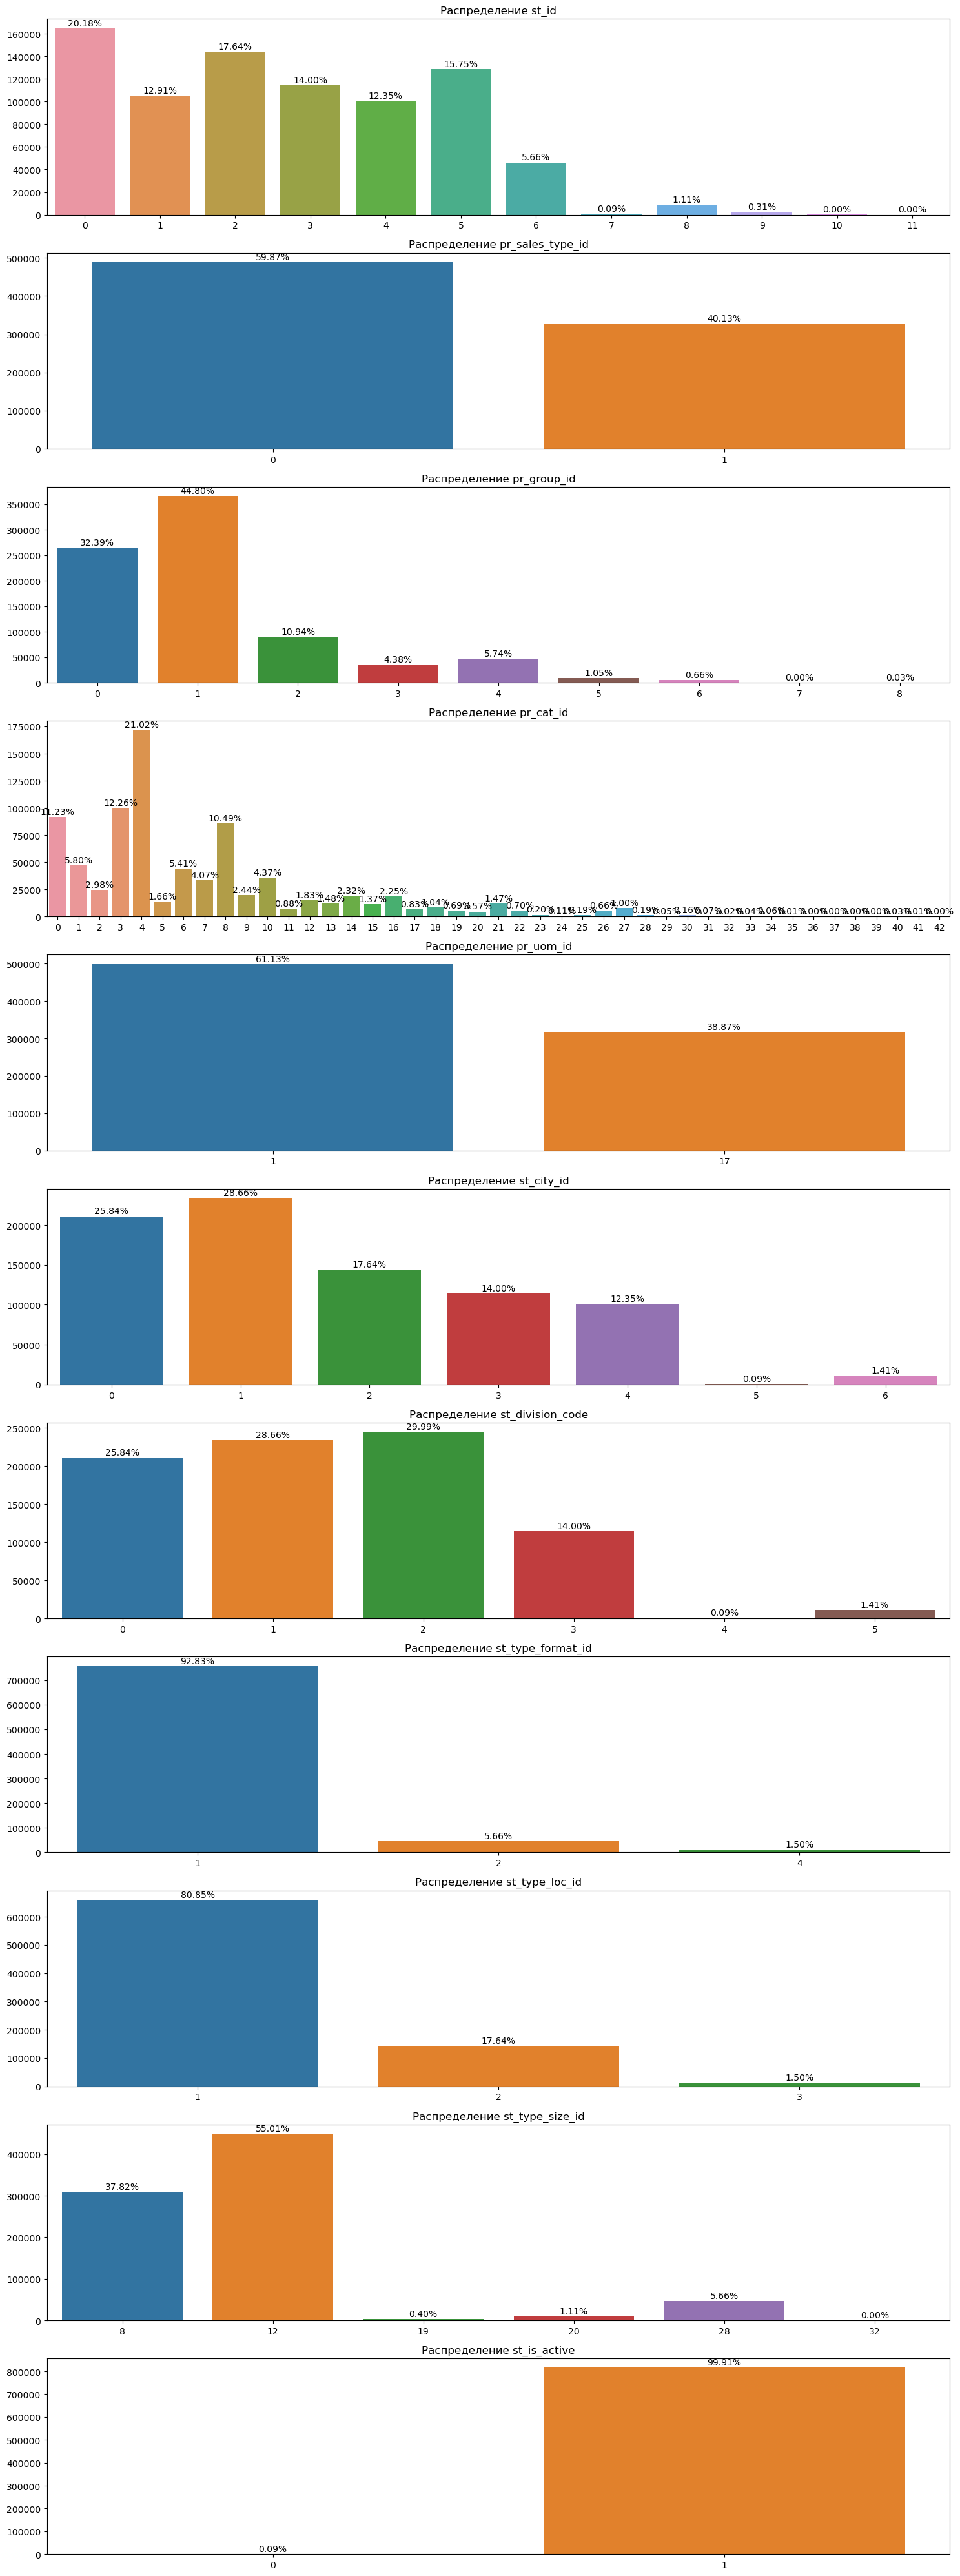

In [23]:
cols = 1
rows = len(cat_cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 40), dpi=100)

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df_num, x=col, ax=ax)
    ax.set_title(f"Распределение {col}")
    ax.set(xlabel=None, ylabel=None)

    total = len(df_num)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

На основе графиков можно сделать следующие выводы:

1. В группировке товаров можно выделить топ-3:
      * Группа №1 - 44,8%
      * Группа №0 - 32,39%
      * Группа №2 - 10.94%
      
      
2. В нашем распоряжении данные 12 магазинов. Очень мало данных о магазинах с номером 7, 9, 10 и 11. Продажи этих магазинов составляют менее 1% от общего обьема данных.


3. Среди категорий товара также можно выделить ТОП наиболее продаваемых категорий:
     * Категория №4 - 21.02%
     * Категория №3 - 12.26%
     * Категория №0 - 11.23%
     * Категория №8 - 10.49% 
     
4. Магазины располагаются в 7 городах. Самые прибыльные города 1,0 и 2. На эти города приходится более 50% продаж. Меньше всего продаж приходится на города 5 и 6. Продажи в этих городах составляют менее 2% от общего обьема продаж.


5. В столбце st_is_active представлена о статусе активности магазина в настоящее время. Видно, что в данных присутствует малое количество неактивных магазинов. Их необходимо исключить. И столбец st_is_active можно будет после этого удалить, т.к. не будет нести никаой смысловой информации для нас.

6. В столбце st_type_size_id со значением 32 имеет количество практически равное нулю.

На графиках были видны магазин с малым количеством информации. Это магазины 7, 9, 10 и 11. Неплохо изучить информацию о самих магазинах, поскольку малое количество информации может быть из-за того, что магазин недавно только открыли. 

Для начала составим информацию о каждом магазине: его продажах, уникальных товаров, наиболее популярных товарах, дивизионе магазина, формате, городе, типе локации и размере.

In [24]:
unique_sku_by_store = {}

df_grouped = df_num.groupby('st_id')

for store_id, df_store in df_grouped:
    pr_sku_id_store = df_store['pr_sku_id'].unique()
    unique_sku_id = []
    
    for pr in pr_sku_id_store:
        num = len(df_grouped.get_group(store_id).query('pr_sku_id == @pr'))
        if num == 1:
            unique_sku_id.append(pr)
    
    store_name = df_store['st_id'].iloc[0]
    first_sale_date = df_store['date'].min()
    last_sale_date = df_store['date'].max()
    total_sales = round(df_store['pr_sales_in_rub'].sum(), 2)
    popular_items = df_store.groupby(['pr_cat_id', 'pr_sku_id']).agg({'pr_sales_in_units': 'sum', 'pr_sales_in_rub': 'sum'}).nlargest(5, 'pr_sales_in_units')
    percent_unique_sku = round(len(unique_sku_id) / len(pr_sku_id_store) * 100, 2)
    sity_name = df_store['st_city_id'].unique()
    store_division_id = df_store['st_division_code'].unique()
    form_store = df_store['st_type_format_id'].unique()
    type_loc_store = df_store['st_type_loc_id'].unique()
    type_size_store = df_store['st_type_size_id'].unique()
    
    
    unique_sku_by_store[store_id] = {
        'Наименование магазина': store_name,
        'Город': sity_name,
        'Дивизион магазина': store_division_id,
        'Формат магазина': form_store,
        'Тип локации/окружения магазина': type_loc_store, 
        'Тип размера магазина': type_size_store,
        'Дата первой продажи': first_sale_date,
        'Дата последней продажи': last_sale_date,
        'Уникальные позиции магазина': unique_sku_id,
        'Сумма продаж за все время': total_sales,
        'Процент уникальных товаров': percent_unique_sku,
        'Наиболее популярные товары': popular_items,
    }

for store_id, store_data in unique_sku_by_store.items():
    print('*'*100)
    print(f"Store ID: {store_id}")
    for key, value in store_data.items():
        print(f"{key}: {value}")
    print('*'*100)
    print()

****************************************************************************************************
Store ID: 0
Наименование магазина: 0
Город: [0]
Дивизион магазина: [0]
Формат магазина: [1]
Тип локации/окружения магазина: [1]
Тип размера магазина: [8]
Дата первой продажи: 2022-08-01 00:00:00
Дата последней продажи: 2023-07-18 00:00:00
Уникальные позиции магазина: [340, 597, 625, 765, 777, 801, 806, 839, 857, 902, 934, 940, 977, 984, 990, 1009, 1017, 1031, 1039, 1046, 1053, 1054, 1061, 1062, 1068, 1071, 1078, 1079, 1081, 1084]
Сумма продаж за все время: 109380512.82
Процент уникальных товаров: 2.79
Наиболее популярные товары:                      pr_sales_in_units  pr_sales_in_rub
pr_cat_id pr_sku_id                                    
4         45                   42088.0        1999391.0
          532                  27146.0        1546101.0
          43                   22350.0         335688.0
10        196                  19296.0        2362788.0
9         70                

* У большинства магазинов есть свои уникальные товары, которые продаются, то в их магазине. Исключением из этого являются магазины 7 и 11. В этих магазинах нет уникальных товаров, характерных только для этих магазинов. 

* Магазин с id 10 имеет малое количество продаж. Судя по датам этот магазин относительно недавно открылся, поэтому информации по нему крайне мало. Исключать этот магазин из анализа не будем, поскольку в этом городе этот магазин не единственный.  

* Магазин с id 7 имеет крайне странные продажи(ровно 1 месяц).При этом даты продаж приходятся на август 2022 года. Обьем таких продаж крайне мал, поэтому этот магазин также исключаем из дальнейшего анализа.

* Магазин с id 11 не информативен для нас, поскольку осуществлял продажи только в период с 24 августа по 8 сентября 2022, при этом сумма продаж составила всего лишь 3498 рублей и продавали всего лишь 2 позиции. Поэтому этот магазин тоже необходимо исключить.


Также на графиках видно, что у нас представлено очень маленькое количество товаров 6, 5, 7 и 8 группы. Такие группы следует исключить из дальнейшего исследования.

Исключим данные, которые было решено убрать.

In [25]:
df_num = df_num.query('st_id != (7, 11)')
df_num = df_num.query('pr_group_id != (6, 5, 7, 8)')
df_num = df_num.query('st_is_active != 0')
df_num = df_num.drop('st_is_active', axis=1)

Посмотрим ТОП-10 наиболее продаваемых товаров по месяцам.

In [26]:
df_copy = df_num.copy()
df_copy['year_month'] = pd.to_datetime(df_copy['date']).dt.to_period('M')

monthly_sales = df_copy.groupby(['pr_sku_id', 'year_month'])[['pr_sales_in_units', 'pr_sales_in_rub']].sum()
monthly_sales = monthly_sales.reset_index()

print('*'*100)
print("Сумма продаж за весь период:", monthly_sales['pr_sales_in_rub'].sum().round(2))

popular_items = monthly_sales.groupby(['pr_sku_id']).agg({'pr_sales_in_units': 'sum'}).nlargest(10, 'pr_sales_in_units')
popular_items_names = popular_items.index.tolist()
print(f"Топ-10 наиболее продаваемых товаров: {popular_items_names}")

print('*'*100)

for year_month, month_group in monthly_sales.groupby('year_month'):
    year = year_month.year
    month = year_month.month
    print('-'*100)
    print(f"\nМесяц: {calendar.month_name[month]} {year}")
    print("Сумма продаж за месяц:", month_group['pr_sales_in_rub'].sum().round(2))

    top_10_items_month = month_group.nlargest(10, 'pr_sales_in_units')['pr_sku_id']
    print("Топ-10 товаров по продажам за месяц:", ', '.join(map(str, top_10_items_month)))

****************************************************************************************************
Сумма продаж за весь период: 506799797.32
Топ-10 наиболее продаваемых товаров: [43, 154, 70, 91, 20, 282, 17, 246, 205, 25]
****************************************************************************************************
----------------------------------------------------------------------------------------------------

Месяц: August 2022
Сумма продаж за месяц: 44703994.01
Топ-10 товаров по продажам за месяц: 43, 154, 70, 20, 282, 205, 133, 187, 25, 151
----------------------------------------------------------------------------------------------------

Месяц: September 2022
Сумма продаж за месяц: 39954582.11
Топ-10 товаров по продажам за месяц: 43, 154, 70, 20, 282, 17, 25, 53, 246, 91
----------------------------------------------------------------------------------------------------

Месяц: October 2022
Сумма продаж за месяц: 39570272.29
Топ-10 товаров по продажам за месяц: 43, 

* Самые прибыльные месяца: декабрь, июнь, май. Скорее всего это связано с Новым годом, майскими праздниками и началом лета. В начале лета многие могут ехать загород и устаривать пикники. 
* Месяца с самыми низкими продажами: июль, февраль, январь. Спад продаж в январе вполне обьясним, поскольку продуктами население массово закупается в конце декабря. Возможно это связано с финансовой составляющей населения. Перед Новым Год население тратит очень много денег, а после празника снижает свои затраты. 
* Наиболее популярные товары за весь период: 43, 154, 70, 91, 20, 282, 17, 246, 205 и 25


Необходимо изучить информацию по продажам во времени для каждого города.

In [27]:
monthly_sales_city = df_copy.groupby(['st_city_id', 'pr_sku_id', 'year_month'])[['pr_sales_in_units', 'pr_sales_in_rub']].sum()
monthly_sales_city = monthly_sales_city.reset_index()

all_cities_items = set(df_copy['pr_sku_id'])

for city_id, city_group in monthly_sales_city.groupby('st_city_id'):
    print('*'*100)
    print(f"\nГород ID: {city_id}")
    
    print("Сумма продаж за весь период:", city_group['pr_sales_in_rub'].sum().round(2))
    
    popular_items = city_group.groupby(['pr_sku_id']).agg({'pr_sales_in_units': 'sum'}).nlargest(10, 'pr_sales_in_units')
    popular_items_names = popular_items.index.tolist()
    print(f"Топ-10 наиболее продаваемых товаров: {popular_items_names}")

    city_items = set(city_group['pr_sku_id'])
    other_cities_items = set(monthly_sales_city[monthly_sales_city['st_city_id'] != city_id]['pr_sku_id'])
    unique_items_to_city = list(city_items.difference(other_cities_items))
    
    print(f"Количество уникальных товаров: {len(unique_items_to_city)}")
    print('*'*100)
    for year_month, month_group in city_group.groupby('year_month'):
        year = year_month.year
        month = year_month.month
        print('-'*100)
        print(f"\nМесяц: {calendar.month_name[month]} {year}")
        print("Сумма продаж за месяц:", month_group['pr_sales_in_rub'].sum().round(2))

        top_10_items_month = month_group.nlargest(10, 'pr_sales_in_units')['pr_sku_id']
        print("Топ-10 товаров по продажам за месяц:", ', '.join(map(str, top_10_items_month)))

****************************************************************************************************

Город ID: 0
Сумма продаж за весь период: 113512344.21
Топ-10 наиболее продаваемых товаров: [45, 532, 43, 196, 273, 70, 282, 154, 91, 124]
Количество уникальных товаров: 355
****************************************************************************************************
----------------------------------------------------------------------------------------------------

Месяц: August 2022
Сумма продаж за месяц: 9367973.69
Топ-10 товаров по продажам за месяц: 723, 43, 273, 282, 70, 17, 154, 196, 711, 124
----------------------------------------------------------------------------------------------------

Месяц: September 2022
Сумма продаж за месяц: 9057674.84
Топ-10 товаров по продажам за месяц: 43, 282, 17, 273, 154, 70, 124, 117, 711, 24
----------------------------------------------------------------------------------------------------

Месяц: October 2022
Сумма продаж за месяц: 9

Топ-10 товаров по продажам за месяц: 668, 43, 846, 154, 70, 91, 282, 205, 56, 1359
----------------------------------------------------------------------------------------------------

Месяц: May 2023
Сумма продаж за месяц: 10182995.26
Топ-10 товаров по продажам за месяц: 43, 91, 154, 70, 282, 246, 205, 25, 56, 187
----------------------------------------------------------------------------------------------------

Месяц: June 2023
Сумма продаж за месяц: 9636134.08
Топ-10 товаров по продажам за месяц: 43, 154, 282, 205, 70, 91, 246, 56, 25, 187
----------------------------------------------------------------------------------------------------

Месяц: July 2023
Сумма продаж за месяц: 6050840.38
Топ-10 товаров по продажам за месяц: 43, 91, 282, 154, 70, 187, 56, 25, 205, 1358
****************************************************************************************************

Город ID: 3
Сумма продаж за весь период: 72817169.59
Топ-10 наиболее продаваемых товаров: [1505, 91, 43, 154, 20

* Топ cамых продаваемых товаров за все время в большинстве городов: 43, 154, 70, 91.
* Наиболее продаваемые товары города 6 отличаются от остальных городов. Возможно это обосуловлено предпочтениями населения в данном городе.
* Топ-3 самых прибыльных городов:
  * Город ID: 1 - 149 122 692.93
  * Город ID: 0 - 113 512 344.21
  * Город ID: 2 - 1076 394 932.08
* Самый прибыльный месяц по городам - декабрь. Исключение составляет город ID: 6. Для этого города самым прибыльным месяцем оказался июнь.

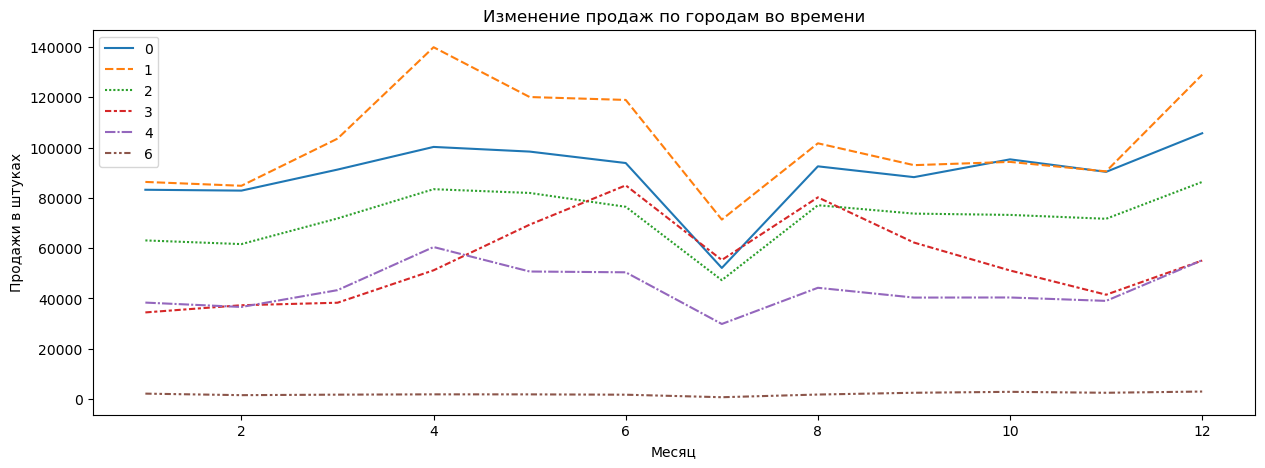

In [28]:
# Подготовка данных для графика
df_plot = df_num.copy()
df_plot.set_index('date', inplace=True)
pivot_table = df_plot.pivot_table(index=df_plot.index.month, columns='st_city_id', values='pr_sales_in_units', aggfunc='sum')

# Создание графика
plt.figure(figsize=(15, 5))
sns.lineplot(data=pivot_table)

plt.legend(loc='upper left')
plt.xlabel('Месяц')
plt.ylabel('Продажи в штуках')
plt.title('Изменение продаж по городам во времени')

plt.show()

* Среди городов можно выделить ТОП-3 самых прибыльных: город №1, город №0, город №2.
* Меньше всего продаж приходится на город №6.

Посмотрим на распределение продаж в штуках во времени.

In [29]:
# Создание среза таблицы для просмотра общих продаж в штуках во времени 
df_a = df_num[['date', 'pr_sales_in_units']]
df_a = set_date_index(df_a, 'date')
df_a = df_a.resample('1d').sum()

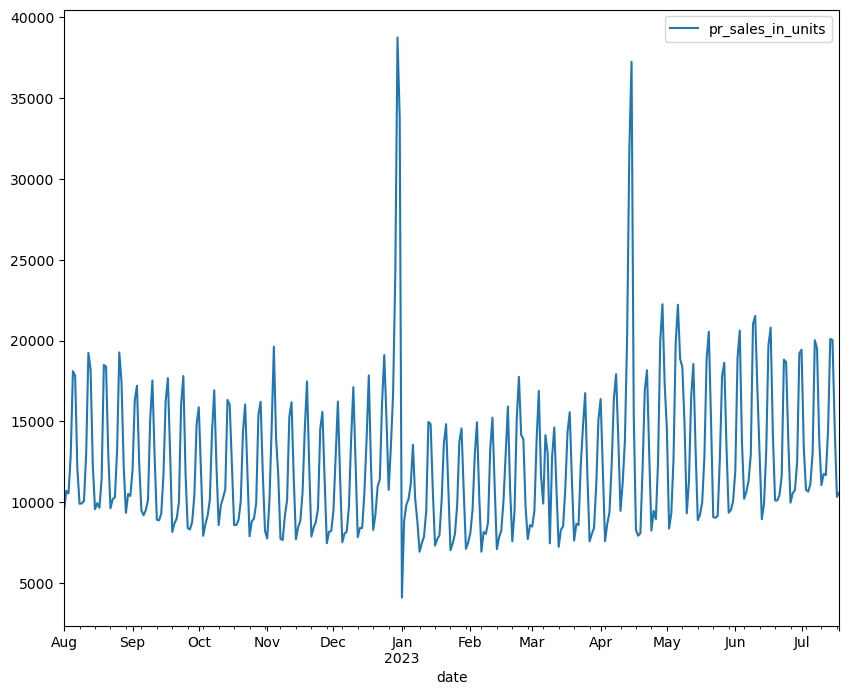

In [30]:
# Вывод графика распределения общих продаж
df_a.plot(figsize=(10, 8))
plt.show()

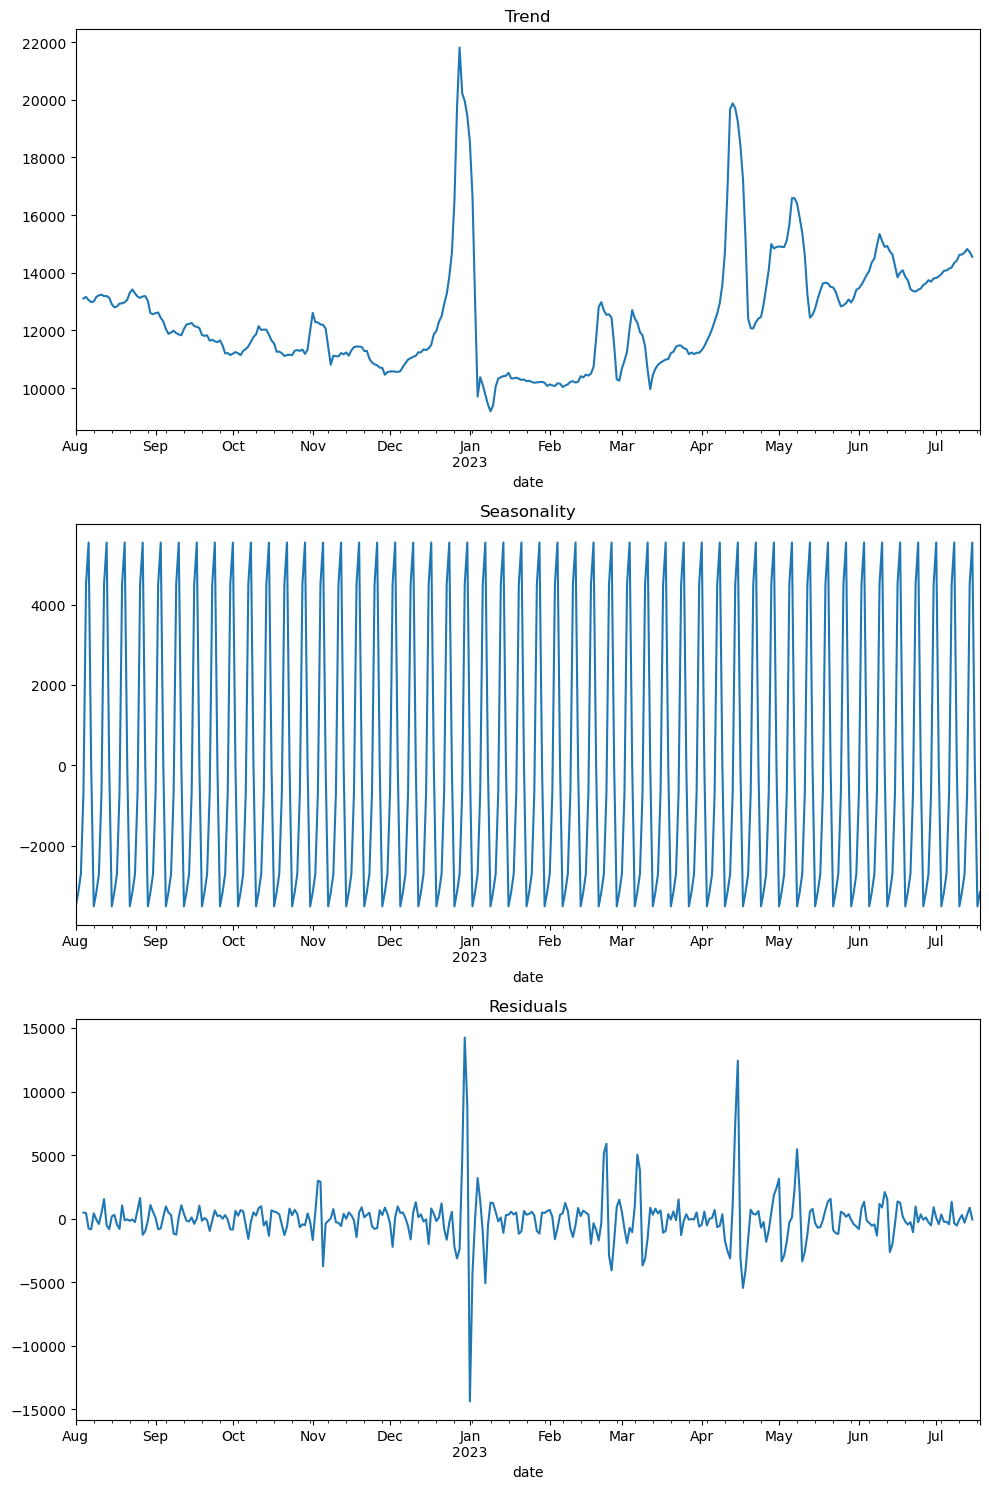

In [31]:
# Визуализация трендов,сезонности общих продаж во времени
decomposed = seasonal_decompose(df_a)

plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По полученным графикам видно, что в конце декабря имеется очень большой скачок продаж, а потом резкое падение. Такой подьем продаж можно объяснить тем, что происходит празднование Нового года. А вот падение приходится на начало января. Это может быть связано со списанием товаров с ограниченным сроком годности.


В целом на графике с трендами видны всплески продаж в период праздников. Например,  в конце февраля - начале марта (23 февраля, 8 марта, масленица) или апрель - май (пасха, 1 мая, 9 мая). Самый низкий тред продаж на графике - это январь-февраль, самый высокий декабрь.

Посмотрим распределение продаж за последние две недели в данных, т.к. график сезонности был не очень информативен.

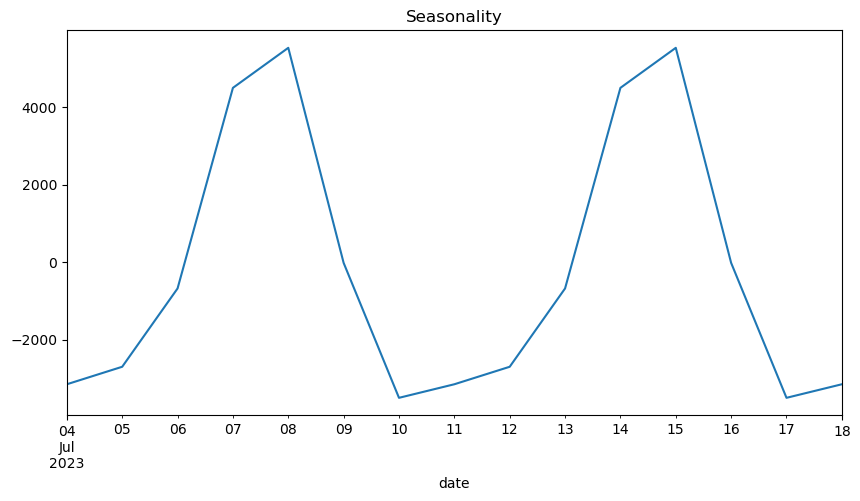

In [32]:
plt.figure(figsize=(10, 5))
decomposed.seasonal['2023-07-04':'2023-07-18'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.show()

Исходя из графика можно сделать выводы, что пик продаж приходится на выходные дни, а вот в понедельник происходит резкое падение продаж до минимума.

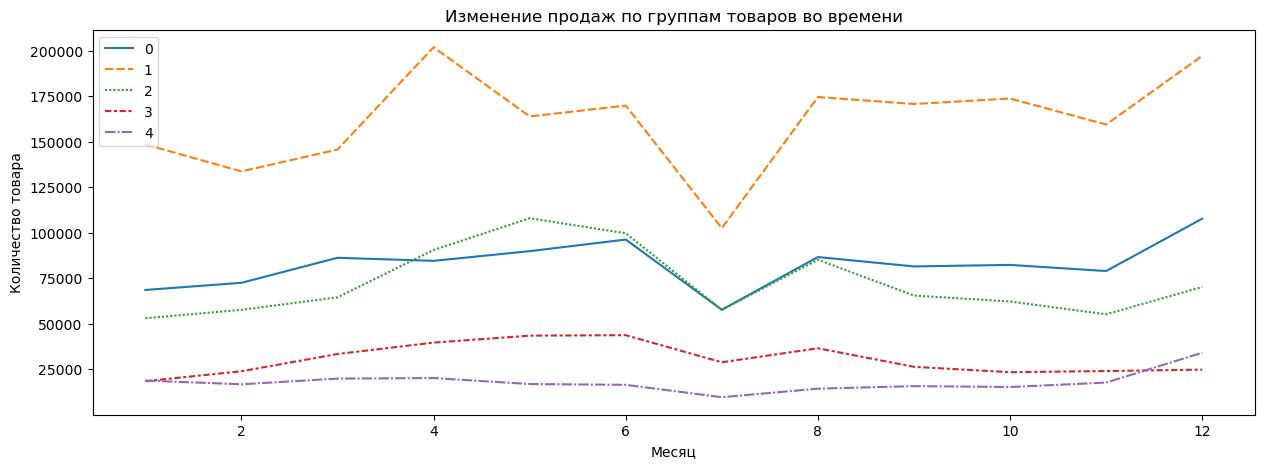

In [33]:
#  Визуализация распределения общих продаж каждой группы товаров во времени
df_plot = df_num[['date', 'pr_group_id', 'pr_sales_in_units']].copy()
df_plot = set_date_index(df_plot, 'date')
pivot_table = df_plot.pivot_table(index=df_plot.index.month, columns='pr_group_id', values='pr_sales_in_units', aggfunc='sum')


plt.figure(figsize=(15, 5))
sns.lineplot(data=pivot_table)

plt.legend(loc='upper left')
plt.xlabel('Месяц')
plt.ylabel('Количество товара')
plt.title('Изменение продаж по группам товаров во времени')

plt.show()

* Больше всего продаж приходится на 1 группу товаров. На втором и третьем месте группа товаров №0  и группа товаров №2.
* Меньше всего спросом пользуется группа товаров №4

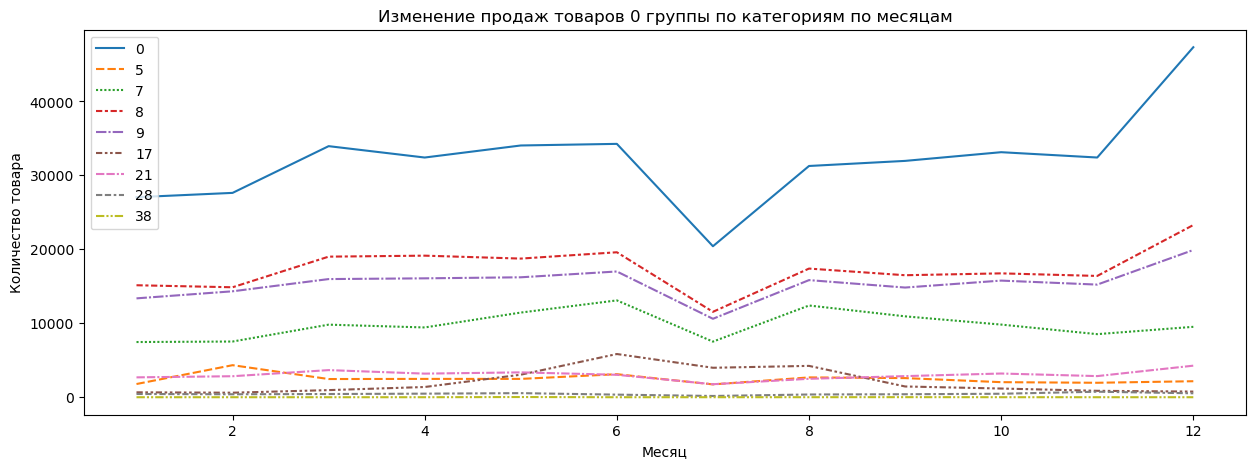

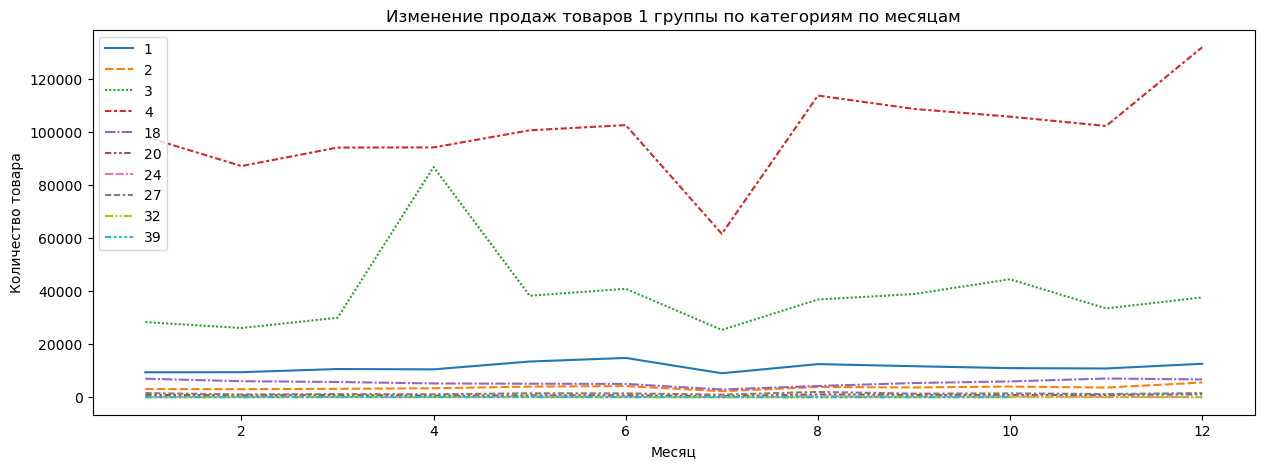

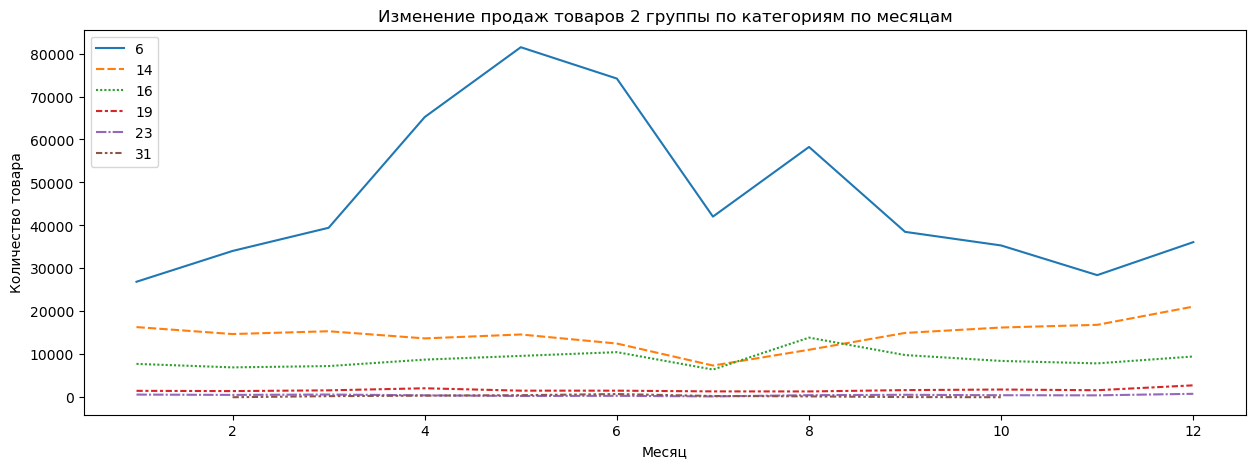

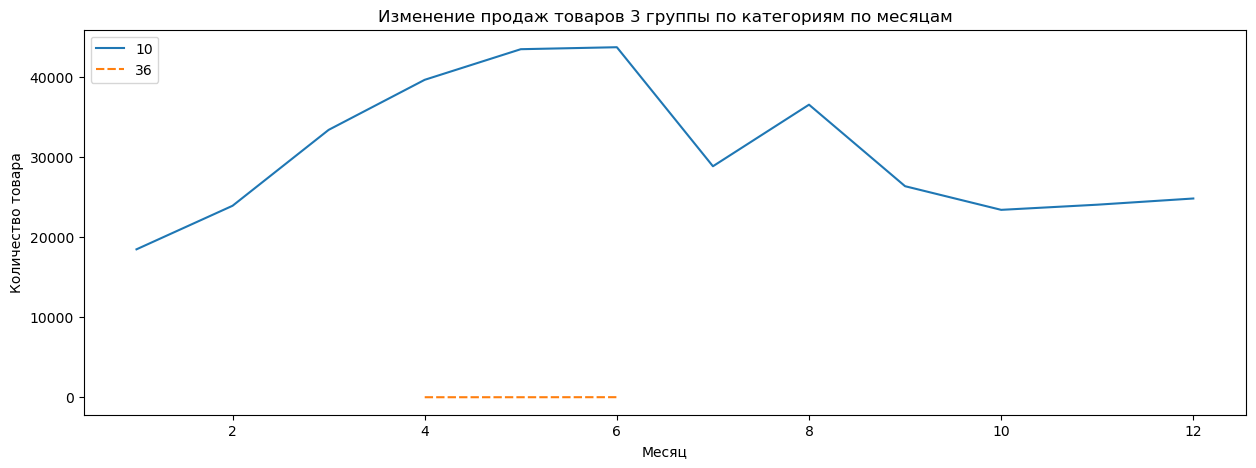

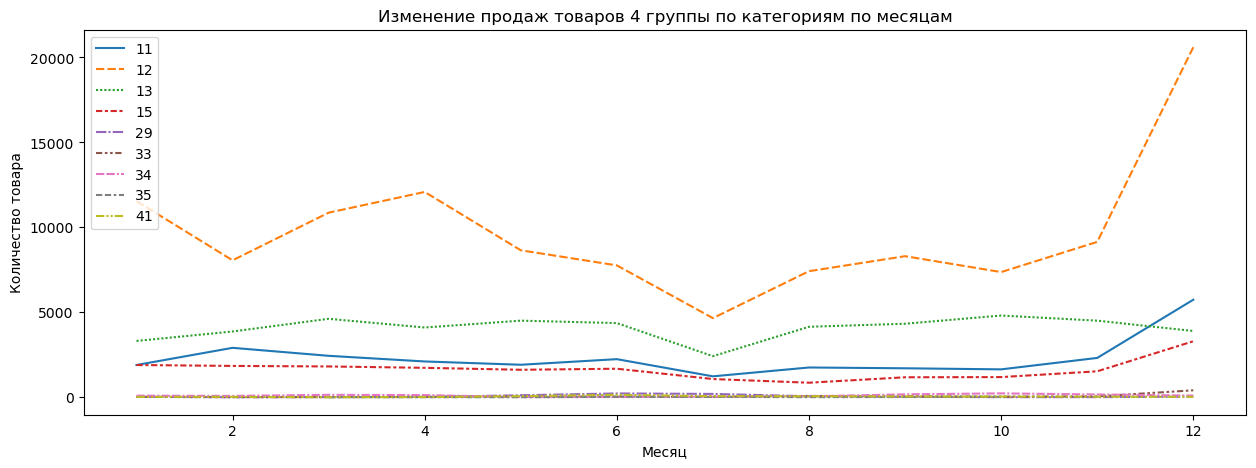

In [34]:
# Визуализация продаж категорий товаров внутри групп во времени
name_group_id = df_num['pr_group_id'].unique()

for name in name_group_id:
    plot_cat_sales(df_num, name,  'date', 'pr_group_id', 'pr_cat_id', 'pr_sales_in_units')
    

На графике 3 группы товаров странное отображение категорий товаров 36. Категория 36 продавалась с апреля по июнь. Сделаем срез по этой категории и посмотрим, на продажи этих товаров.

In [35]:
df_num.query('pr_cat_id == 36')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price
172342,0,910,2023-06-06,0,1.0,0.0,115.0,0.0,3,36,118,1,0,0,1,1,8,115.00
172343,0,910,2023-05-01,0,1.0,0.0,113.0,0.0,3,36,118,1,0,0,1,1,8,113.00
172344,0,910,2023-06-23,0,1.0,0.0,252.0,0.0,3,36,118,1,0,0,1,1,8,252.00
172345,0,910,2023-06-03,0,1.0,0.0,115.0,0.0,3,36,118,1,0,0,1,1,8,115.00
172346,0,910,2023-05-26,0,2.0,0.0,338.0,0.0,3,36,118,1,0,0,1,1,8,169.00
172347,0,910,2023-06-24,0,1.0,0.0,252.0,0.0,3,36,118,1,0,0,1,1,8,252.00
172348,0,910,2023-04-28,0,1.0,0.0,111.0,0.0,3,36,118,1,0,0,1,1,8,111.00
172349,0,910,2023-05-24,0,1.0,0.0,225.0,0.0,3,36,118,1,0,0,1,1,8,225.00
172350,0,910,2023-05-07,1,1.0,1.0,97.0,97.0,3,36,118,1,0,0,1,1,8,97.00
172351,0,910,2023-04-29,0,1.0,0.0,113.0,0.0,3,36,118,1,0,0,1,1,8,113.00


Товары категории 36 присутствуют в минимальном количестве. Судя по датами эта новая категория, которую ввели в ассортимент совсем недавно.

Построим график кол-ва проданных, скользящего среднего и стандартного отклонения.

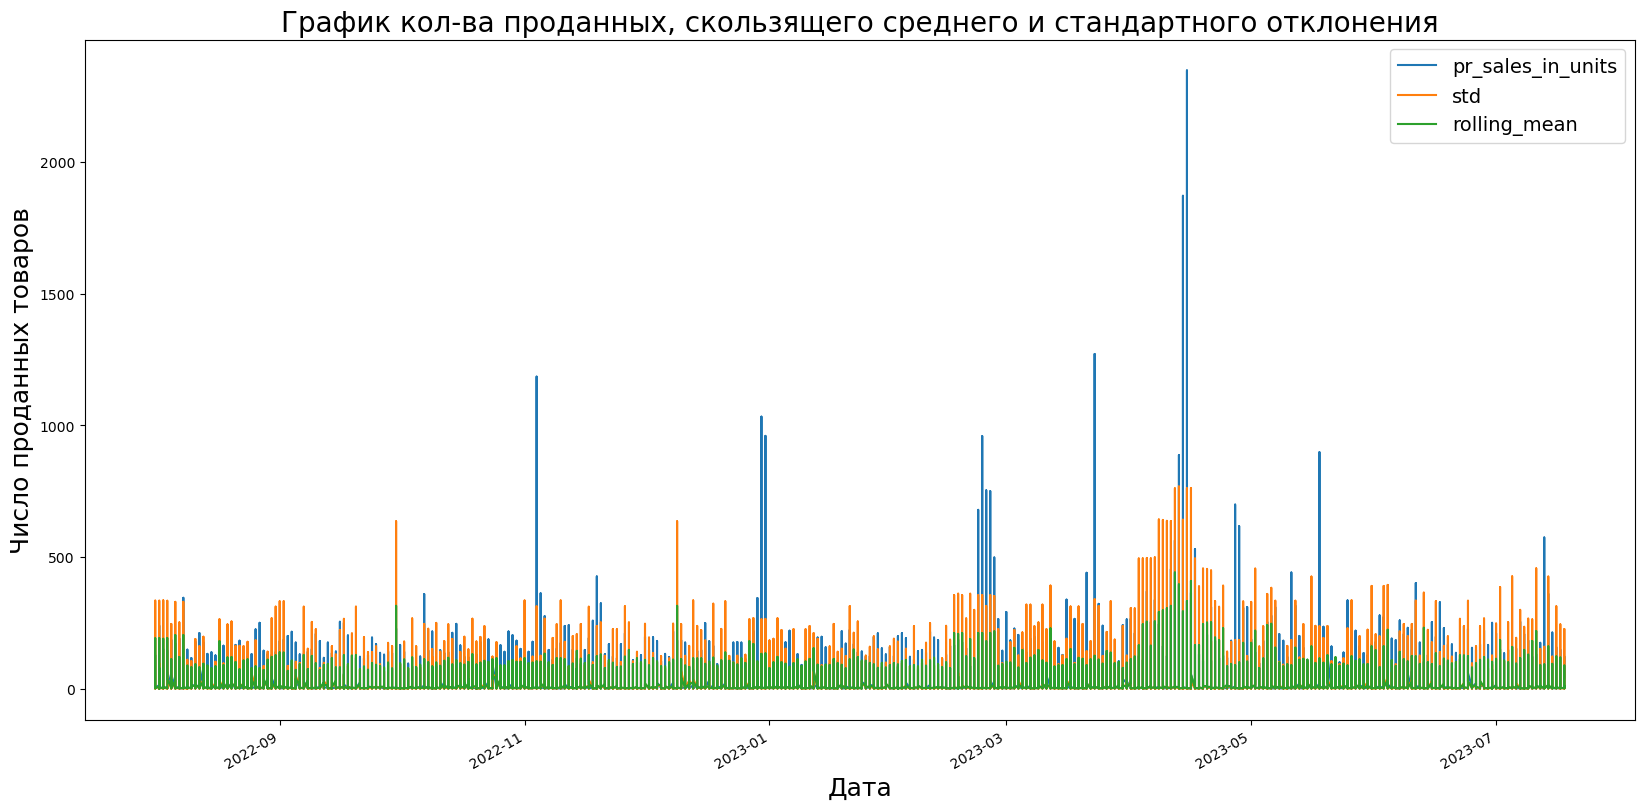

In [36]:
units_mean_std = df_num.copy()

units_mean_std['rolling_mean'] = units_mean_std['pr_sales_in_units'].rolling(14).mean()
units_mean_std['std'] = units_mean_std['pr_sales_in_units'].rolling(14).std()

ax = units_mean_std[['date', 'pr_sales_in_units', 'std', 'rolling_mean']].plot(figsize=(20, 10), 
                                                                              x='date')

ax.set_title('График кол-ва проданных, скользящего среднего и стандартного отклонения', fontsize=20)
ax.set_xlabel('Дата', fontsize=18)
ax.set_ylabel('Число проданных товаров', fontsize=18)
ax.legend(fontsize=14)
plt.show()


На графике видно, что есть сильные всплески в период с марта по май. Тут самое большое количество проданных товаров. Одним вариантом обьяснения такого всплеска может быть наличие праздника(например Пасха, 1 мая, 9 мая).  

Также присутствуют всплески в ноябре и в период с декабря по март. Но не очень большие по сравнению со всплеском в период с марта по май. 

Посмотрим более подробно период с марта по май. Выведем инфомацию по неделям и посмотрим на продажи каждого магазина 

In [37]:
df_april = df_num[(df_num['date'] > '2023-04-01') & (df_num['date'] < '2023-04-30')]
df_may = df_num[(df_num['date'] > '2023-05-01') & (df_num['date'] < '2023-05-31')]

print('Количество проданного товараза апрель:', df_april['pr_sales_in_units'].sum())
print('Количество проданного товараза май:', df_may['pr_sales_in_units'].sum())

Количество проданного товараза апрель: 403364.0
Количество проданного товараза май: 397628.0


In [38]:
# Применяем функцию к срезам данных по месяцам
analyze_month(df_april, 'Апрель')

Месяц: Апрель
****************************************************************************************************

Топ-5 товаров за месяц:
pr_sku_id
846    21052.0
668    21024.0
91     10465.0
70      9407.0
43      8632.0
Name: pr_sales_in_units, dtype: float64
****************************************************************************************************
Продажи в штуках по неделям:
date
2023-04-02     11994.0
2023-04-09     86272.0
2023-04-16    139139.0
2023-04-23     84542.0
2023-04-30     81417.0
Name: pr_sales_in_units, dtype: float64
****************************************************************************************************
Сумма продаж по неделям:
date
2023-04-02     1377352.00
2023-04-09     9659653.65
2023-04-16    13797263.44
2023-04-23     9456315.22
2023-04-30     9497450.71
Name: pr_sales_in_rub, dtype: float64
****************************************************************************************************

Магазин ID: 0

Город магазина:
0
Сумма прода

При анализе продаж апреля видно, что наибольшие продажи во всех магазинах приходится на период празднования Пасхи (16 апреля). При рассмотрении продаж товаров по магазинам можно выделить следующее:
* Больше всего было продано товаров 846, 668, 91, 70 и 43. 
* При изучении информации о продажах за этот месяц по магазинам и городам выявлено, что меньше всего продаж в магазине 10, расположенный в городе 3. 

Теперь рассмотрим продажи за май.

In [39]:
analyze_month(df_may, 'Май')

Месяц: Май
****************************************************************************************************

Топ-5 товаров за месяц:
pr_sku_id
91     11036.0
246     9689.0
43      9346.0
70      9306.0
154     8812.0
Name: pr_sales_in_units, dtype: float64
****************************************************************************************************
Продажи в штуках по неделям:
date
2023-05-07     91294.0
2023-05-14    102186.0
2023-05-21     95409.0
2023-05-28     89844.0
2023-06-04     18895.0
Name: pr_sales_in_units, dtype: float64
****************************************************************************************************
Сумма продаж по неделям:
date
2023-05-07    10577682.49
2023-05-14    12074692.85
2023-05-21    11206069.73
2023-05-28    10638408.93
2023-06-04     2131716.68
Name: pr_sales_in_rub, dtype: float64
****************************************************************************************************

Магазин ID: 0

Город магазина:
0
Сумма продаж з

При анализе продаж за май  выявлено следующее:
* Суммы продаж в целом распределены равномерно. Но на 9 мая все же приходится чуть больше продаж, чем на остальные недели.
* Топ-5 товаров: 91, 246, 43, 70 и 154.
* Меньше всего продаж приходится на 10 магазин. Также для этого магазина характерен свой топ товаров, который отличается от остальных.

Построим матрицу корреляции данных.

In [40]:
phik_overview = df_num.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['st_id', 'pr_sku_id', 'pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'price']


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price
st_id,1.00,0.56,0.07,0.07,0.00,0.00,0.02,0.02,0.16,0.14,0.20,0.23,1.00,1.00,1.00,1.00,0.94,0.07
pr_sku_id,0.56,1.00,0.07,0.08,0.02,0.02,0.02,0.02,0.29,0.32,0.49,0.17,0.48,0.63,0.69,0.51,0.74,0.08
date,0.07,0.07,1.00,0.11,0.05,0.05,0.05,0.04,0.06,0.04,0.05,0.04,0.07,0.07,0.08,0.06,0.07,0.03
pr_sales_type_id,0.07,0.08,0.11,1.00,0.01,0.02,0.03,0.04,0.14,0.16,0.10,0.07,0.10,0.06,0.03,0.03,0.04,0.04
pr_sales_in_units,0.00,0.02,0.05,0.01,1.00,1.00,0.59,0.58,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pr_promo_sales_in_units,0.00,0.02,0.05,0.02,1.00,1.00,0.60,0.61,0.02,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pr_sales_in_rub,0.02,0.02,0.05,0.03,0.59,0.60,1.00,1.00,0.06,0.04,0.03,0.02,0.02,0.02,0.01,0.03,0.01,0.09
pr_promo_sales_in_rub,0.02,0.02,0.04,0.04,0.58,0.61,1.00,1.00,0.06,0.04,0.03,0.02,0.02,0.01,0.01,0.03,0.01,0.07
pr_group_id,0.16,0.29,0.06,0.14,0.01,0.02,0.06,0.06,1.00,0.91,0.73,0.54,0.11,0.19,0.15,0.11,0.22,0.36
pr_cat_id,0.14,0.32,0.04,0.16,0.00,0.01,0.04,0.04,0.91,1.00,0.80,0.65,0.12,0.15,0.17,0.11,0.18,0.21


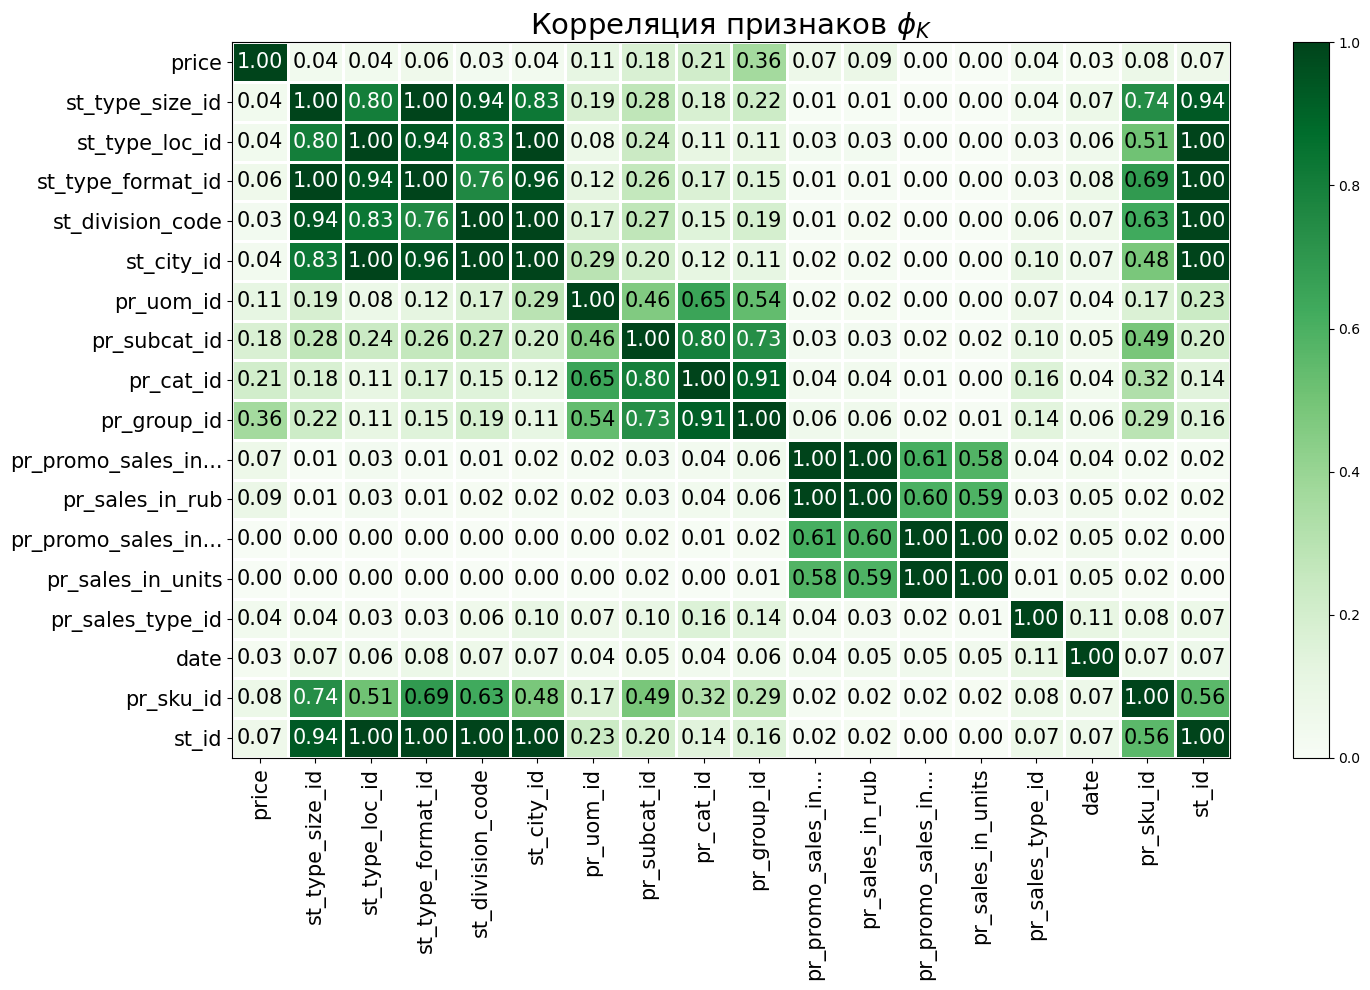

In [41]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция признаков $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

На матрице корреляции видна сильная взаимосвязь некоторых признаков друг с другой. Например, взаимосвязь номера магазина с размером, типом локации, форматом магазина и т.д. 

In [42]:
del units_mean_std
del df_plot
del pivot_table
del df_a
del df
del train
del pr
del st_df
del df_grouped
del phik_overview
del df_copy
del monthly_sales
del monthly_sales_city
del popular_items
del popular_items_names
del all_cities_items
del city_items
del other_cities_items
del unique_items_to_city
del df_may
del df_april

**Вывод:**


**При изучении общего распределения данных было выявлено следующее:**


1. При исследовании групп товаров можно выделить топ-3:
   * Группа №1 - 44,8%
   * Группа №0 - 32,39%
   * Группа №2 - 10.94%
2. В нашем распоряжении данные 12 магазинов из 7 городов. Очень мало данных о магазинах с номером 7, 9, 10 и 11. Продажи этих магазинов составляют менее 1% от общего объёма данных.
3. Среди категорий товара также можно выделить ТОП наиболее продаваемых категорий:
   * Категория №4 - 21.02%
   * Категория №3 - 12.26%
   * Категория №0 - 11.23%
   * Категория №8 - 10.49% 
4. В столбце st_is_active представлена о статусе активности магазина в настоящее время. Видно, что в данных присутствует малое количество неактивных магазинов. Их необходимо исключить. И столбец st_is_active можно будет после этого удалить, т.к. не будет нести никакой смысловой информации для нас.
5. Товары группы 7 и 8 катастрофически малы, поэтому эти группы были исключены из анализа.
6. Также в данных присутствовала информация о товарах с нулевым количество продаж и не нулевой суммой продаж. Эти данные были исключены. А вот данные с нулевыми суммами продаж были заполнены произведением среднего значения цены для каждой позиции товара на количество проданных товаров.
7. Был создан столбец со стоимостью товар за штуку.


**При изучении информации по каждому магазину в отдельности было выявлено следующее:**


1. У большинства магазинов есть свои уникальные товары, которые продаются, только в их магазине. Исключением из этого являются магазины 2 и 6. В этих магазинах нет уникальных товаров, характерных только для этих магазинов.
2. Магазин с id 10 имеет малое количество продаж. Судя по датам этот магазин относительно недавно открылся. 
3. Магазин с id 7 имеет крайне странные продажи (ровно 1 месяц). Объём таких продаж крайне мал.
4. Магазин с id 11 осуществлял продажи только в период с 24 августа по 8 сентября, при этом сумма продаж составила всего лишь 3498 рублей и продавали всего лишь 2 позиции.
5. Исключили информацию из данных о магазинах с id 7, 11, поскольку информации о продажах данных магазинов была крайне мала и не информативна.


**При изучении информации распределения продаж во времени обнаружено следующее:**


1. В конце декабря, в конце февраля – начале марта, апрель – май имеются высокие всплески количества проданных товаров. Это скорее всего связано с праздниками (Новый год, 23 февраля, 8 марта, масленица, пасха, 1 мая, 9 мая). Самые прибыльные месяца: декабрь, май. Исключение составляет город ID: 6. Для этого города самым прибыльным месяцем оказался июнь.
2. В январе - феврале имеется сильное падение количества продаж. Это объяснимо тем, что люди разъехались за город или закупили достаточно продуктов перед новым годом, а также в целом снижением затрат населения на покупку продуктов после праздников. Месяца с самыми низкими продажами: июль, февраль, январь.
3. Было обнаружено, что товар с категорий 24 продавался только с апреля по июнь и в минимальном количестве. Эту категорию исключили, поскольку данных недостаточно для прогнозирования.
4. Наиболее популярные товары за весь период: 43, 154, 70, 91, 20, 282, 17, 246, 205 и 25
5. Наиболее продаваемые товары города 6 отличается от остальных городов. Возможно это обосуловлено предпочтениями населения в данном городе. Топ-3 самых прибыльных городов:
    * Город ID: 1 - 149 122 692.93
    * Город ID: 0 - 113 512 344.21
    * Город ID: 2 - 106 394 932.08
  
* Самый прибыльный месяц по городам - декабрь. 

**При анализе продаж апреля видно, что наибольшие продажи во всех магазинах приходится на период празднования Пасхи (16 апреля). При рассмотрении продаж товаров по магазинам можно выделить следующее:**
* Больше всего было продано товаров 846, 668, 91, 70 и 43. 
* При изучении информации о продажах за этот месяц по магазинам и городам выявлено, что меньше всего продаж в магазине 10, расположенный в городах 3. 

**При анализе продаж за май  выявлено следующее:**
* Суммы продаж в целом распределены равномерно. Но на 9 мая все же приходится чуть больше продаж, чем на остальные недели.
* Топ-5 товаров: 91, 246, 43, 70 и 154.
* Меньше всего продаж приходится на 10 магазин. Также для этого магазина характерен свой топ товаров, который отличается от остальных.

# Feature engineering

### Создание календаря праздиков в качестве признака.

Созданим новые признаки. Создадим признка указывающий, является ли день праздником или нет. Данные о праздиках содержится в датафрейме holiday.

In [43]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


In [44]:
holiday['date'] = pd.to_datetime(holiday['date'], format="%d.%m.%Y", infer_datetime_format=True)

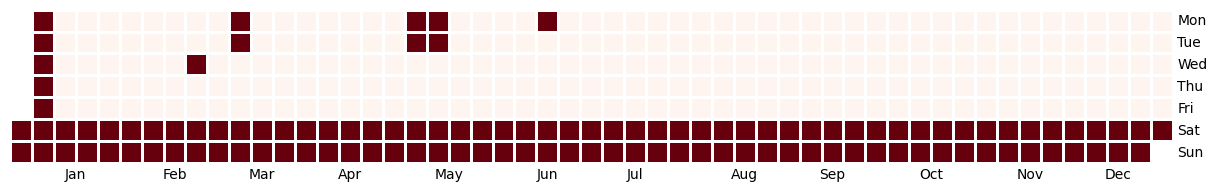

In [45]:
# Построение тепловой карты-календаря
hol = pd.DataFrame(list(holiday['holiday']), index=holiday['date'])
plt.figure(figsize=(15, 15))
calmap.yearplot(hol, year=2022);

In [46]:
# Объединение датафреймов, удалиние лишних столбцов
df_num = pd.merge(df_num, holiday, on='date').drop(['year', 'day', 'weekday', 'calday','covid'], axis=1)

In [47]:
df_num.sample(5)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price,holiday
758851,4,163,2023-03-15,0,1.0,0.0,105.0,0.0,0,7,13,17,4,2,1,1,12,105.0,0
400123,5,257,2022-10-01,0,1.0,0.0,107.0,0.0,0,0,27,1,1,1,1,1,12,107.0,1
162943,2,765,2023-01-15,0,2.0,0.0,675.0,0.0,0,0,0,1,2,2,1,2,8,337.5,1
188553,0,123,2023-01-06,0,5.0,0.0,201.0,0.0,2,19,60,1,0,0,1,1,8,40.2,1
326092,1,6,2023-03-19,0,2.0,0.0,417.0,0.0,0,0,5,1,1,1,1,1,12,208.5,1


### Создание дополнительных лаговых и временных признаков



* pr_sales_in_units_lag - общие продажи за 14 дней в штуках с группировкой по категориям товаров.
* pr_sales_in_rub_lag - общие продажи за 14 дней в рублях с группировкой по категориям товаров..
* pr_sales_in_units_max_lag - максисмальная сумма продаж в штуках за 14 дней с группировкой по категориям товаров.
* pr_sales_in_units_min_lag - минимальная сумма продаж в штуках за 14 дней с группировкой по категориям товаров.
* pr_sales_in_rub_max_lag - максисмальная сумма продаж в рублях за 14 дней с группировкой по категориям товаров.
* pr_sales_in_rub_min_lag - минимальная сумма продаж в рублях за 14 дней с группировкой по категориям товаров.
* mean sales_week_lag - среднее значение продаж за последние 14 дней для каждой группы.
* lag_feature_weekday - день недели.
* month - месяц.
* quarter - квартал.
* lag_feature_4weeks - продажи за 4 недели без группировок
* lag_feature_1week - продажи за 14 дней без группировки.
* sales_ratio - отношения продаж за 4 недели к продажам за последнюю неделю.
* sales_ratio_cat - отношения продаж товара к продажам во всей категории.
* sales_slope_7d - угловой коэффициент графика продаж товара за последние 14 дней
* pr_sales_in_units_lag_city - продажи в штуках за 14 дней, с группировкой по городам.
* pr_sales_in_rub_lag_city - продажи в рублях за 14 дней, с группировкой по городам.
* pr_sales_in_units_lag_local_type - продажи в штуках за 14 дней, с группировкой по городам.
* pr_sales_in_rub_lag_local_type - продажи в штуках за 14 дней, с группировкой по городам.
* seasonality_index - индекс сезонности в продаж для каждого магазина.

In [48]:
def generate_features(df_num):
    df_num = df_num.sort_values('date', ascending=False)
    df_num = df_num.assign(
        pr_sales_in_units_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].shift(14),
        pr_sales_in_rub_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].shift(14),
        pr_sales_in_units_max_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=14, min_periods=1).max()),
        pr_sales_in_units_min_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=14, min_periods=1).min()),
        pr_sales_in_rub_max_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=14, min_periods=1).max()),
        pr_sales_in_rub_min_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=14, min_periods=1).min()),
        mean_sales_week_lag=df_num.groupby(['pr_cat_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.rolling(window=14).mean()),
        lag_feature_weekday=df_num['date'].dt.weekday.shift(1),
        month=df_num['date'].dt.month,
        quarter=df_num['date'].dt.quarter,
        lag_feature_4weeks=df_num['pr_sales_in_units'].rolling(window=29).sum(),
        lag_feature_1week=df_num['pr_sales_in_units'].rolling(window=14).sum(),
        sales_ratio=lambda x: x['lag_feature_4weeks'] / x['lag_feature_1week'],
        sales_ratio_cat=df_num['pr_sales_in_units'] / df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform('sum'),
        lag_dayofyear=df_num['date'].dt.dayofyear,
        sales_slope_7d=df_num['pr_sales_in_units'].rolling(window=14).apply(lambda x: np.polyfit(range(14), x, 1)[0], raw=True),
        pr_sales_in_units_lag_city=df_num.groupby('st_city_id')['pr_sales_in_units'].shift(14),
        pr_sales_in_rub_lag_city=df_num.groupby('st_city_id')['pr_sales_in_rub'].shift(14),
        pr_sales_in_units_lag_local_type=df_num.groupby('st_type_loc_id')['pr_sales_in_units'].shift(14),
        pr_sales_in_rub_lag_local_type=df_num.groupby('st_type_loc_id')['pr_sales_in_rub'].shift(14),
        seasonality_index=df_num.groupby('st_id')['pr_sales_in_units'].transform(lambda x: x / x.mean())
    )
   
    df_num.set_index('date', inplace=True)
    
    for i in range(1, 15):
        df_num[f'units_lag_{i}_units'] = df_num.groupby('pr_cat_id')['pr_sales_in_units'].shift(i)

    
    df_num = df_num.dropna()
    
    return df_num

# Обучение ансамбля моделей для прогнозирования спроса на 14 дней

Прежде чем приступить к обучению разделим данные на обучающий и тестовый в соотношении 9:1. Подбирать параметры и обучать все модели будем на обучающем. Проверять качество будем на тестовой выборке. При разделении необходимо учесть, что данные не должны перемешиваться.

In [49]:
train, test = train_test_split(df_num, shuffle=False, test_size=.1)
train, valid = train_test_split(train, shuffle=False, test_size=.33)

print("Размер обучающей выборки: {:.0%}".format(train.shape[0] / df_num.shape[0]))
print("Размер валидационной выборки: {:.0%}".format(valid.shape[0] / df_num.shape[0]))
print("Размер тестовой выборки: {:.0%}".format(test.shape[0] / df_num.shape[0]))

Размер обучающей выборки: 60%
Размер валидационной выборки: 30%
Размер тестовой выборки: 10%


По условию для тестовой выборки необходимо оставить столбец pr_sales_type_id, при этом всем товарам, которые продавались по акции(флаг промо = 1) присвоить флаг промо = 0.

In [50]:
test['pr_sales_type_id'] = 0

Для решения поставленной задачи было принято решение применить ансамбль моделей.

**Модели первого уровня:**

1. Lasso
2. DecisionTreeRegressor
3. XGBRegressor
5. LGBMRegressor

**Мета-модель** - LinearRegressor.

**Метрика качества** - WAPE.

In [51]:
# Параметры моделей 
tree_params = {
    'DecisionTreeRegressor__max_depth': [3, 5, 7, 10],
    'DecisionTreeRegressor__min_samples_split': [2, 5, 10]
    
}
xgb_params = {
    'XGBRegressor__learning_rate': [0.01, 0.05, 0.1], 
    'XGBRegressor__max_depth': [3, 5, 7, 10, 15],
    'XGBRegressor__n_estimators': [100, 250, 500, 750]
    
}
lgbm_params = {
    'LGBMRegressor__learning_rate': [0.01, 0.05, 0.1], 
    'LGBMRegressor__max_depth': [3, 5, 10, 15],
    'LGBMRegressor__verbosity': [-1], 
    'LGBMRegressor__num_leaves': [50, 80],
    'LGBMRegressor__min_child_samples': [20, 30, 50],
    'LGBMRegressor__n_estimators': [100, 250, 500, 750]
}

ls_params = {
    'Lasso__alpha': [0.01, 0.1, 1.0],
    'Lasso__fit_intercept': [True, False]
}

# Pipeline ансамбля моделей для прогнозирования количества проданного товара.
tree_pipeline_units =Pipeline([
    ('scaler', StandardScaler()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
])

xgb_pipeline_units = Pipeline([
    ('scaler', StandardScaler()),
    ('XGBRegressor', XGBRegressor())
])

lgbm_pipeline_units =Pipeline([
    ('scaler', StandardScaler()),
    ('LGBMRegressor', LGBMRegressor())
])


ls_pipeline_units = Pipeline([
    ('scaler', StandardScaler()),
    ('Lasso', Lasso())
])


# Создание метрики WAPE в качестве scorer
scorer = make_scorer(rolling_wape, greater_is_better=False)

# Создание списков моделей и их параметров, которые будут использоваться на каждом уровне
models_1st_level = [ls_pipeline_units, tree_pipeline_units, xgb_pipeline_units, lgbm_pipeline_units]


params_1st_level = [ls_params,tree_params, xgb_params, lgbm_params]


num_folds = 5

Подбор параметров осуществялется с помощью GridSearch. Для перекресной проверки используется TimeSeriesSplit, поскольку он подходит для работы с временными рядами. Это будет происходит в цикле, в котором для каждой выборки будут генерироваться дополнительные признаки, чтобы оптимизировать процесс.

In [52]:
tscv = TimeSeriesSplit(n_splits=num_folds)
all_models_units= []  # список для хранения лучших моделей на каждом уровне
train_size_increment = len(train) // num_folds
max_train_size = train_size_increment

for model, params in zip(models_1st_level, params_1st_level):
    model_name = list(model.named_steps.values())[1].__class__.__name__
    
    print('*'*100)
    print(f'Модель: {model_name}')
    
    best_model = None
    best_score = float('inf')
    
    for train_index, val_index in tscv.split(train):
        train_slice = train.iloc[train_index[:max_train_size]]
        new_df_slice_train = generate_features(train_slice)
        features_slice_train = new_df_slice_train.drop(['pr_sales_in_units'], axis=1)
        target_slice_train = new_df_slice_train['pr_sales_in_units']
    
        
        val_slice = train.iloc[val_index]
        new_df_slice_val = generate_features(val_slice)
        features_slice_val = new_df_slice_val.drop(['pr_sales_in_units'], axis=1)
        target_slice_val = new_df_slice_val['pr_sales_in_units']
        
        
        grid_search = GridSearchCV(model, params, scoring=scorer, cv=tscv)
        
        with tqdm(total=100, desc='Grid Search') as pbar1:
            grid_search.fit(features_slice_train, target_slice_train)
            best_model = grid_search.best_estimator_
            pbar1.update(100)
        
        # Оценка производительности модели на валидационном срезе
        with tqdm(total=100, desc='Прогнозирование') as pbar2:
            y_pred_val = best_model.predict(features_slice_val)
            val_score = rolling_wape(target_slice_val, y_pred_val)
            pbar2.update(100)

        
        # Сохранение лучшей модели на текущем срезе данных
        if val_score < best_score:
            best_score = val_score
            best_model = best_model
        
        max_train_size += train_size_increment
        
        del train_slice, new_df_slice_train, features_slice_train, target_slice_train
        del val_slice, new_df_slice_val, features_slice_val, target_slice_val
        gc.collect()
    
    all_models_units.append(best_model)
    print(f"Лучшие параметры для {model_name}: {grid_search.best_params_}")
    
    del best_model
    gc.collect()
    
    print(f"WAPE для модели {model_name}: {best_score}")

****************************************************************************************************
Модель: Lasso


Прогнозирование: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3030.59it/s]


Лучшие параметры для Lasso: {'Lasso__alpha': 0.01, 'Lasso__fit_intercept': True}
WAPE для модели Lasso: 0.06643847768311137
****************************************************************************************************
Модель: DecisionTreeRegressor


Прогнозирование: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3023.18it/s]


Лучшие параметры для DecisionTreeRegressor: {'DecisionTreeRegressor__max_depth': 10, 'DecisionTreeRegressor__min_samples_split': 5}
WAPE для модели DecisionTreeRegressor: 0.0296771554941841
****************************************************************************************************
Модель: XGBRegressor


Прогнозирование: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 318.93it/s]


Лучшие параметры для XGBRegressor: {'XGBRegressor__learning_rate': 0.05, 'XGBRegressor__max_depth': 15, 'XGBRegressor__n_estimators': 750}
WAPE для модели XGBRegressor: 0.04196577708424811
****************************************************************************************************
Модель: LGBMRegressor


Прогнозирование: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.32it/s]


Лучшие параметры для LGBMRegressor: {'LGBMRegressor__learning_rate': 0.1, 'LGBMRegressor__max_depth': 15, 'LGBMRegressor__min_child_samples': 20, 'LGBMRegressor__n_estimators': 750, 'LGBMRegressor__num_leaves': 80, 'LGBMRegressor__verbosity': -1}
WAPE для модели LGBMRegressor: 0.039944032863775666


Обучение мета-модели происходит на предсказаниях моделей первого уровня. Для того, чтобы получить предсказания моделей первого уровня, надо сгенерировать признаки для валидационной выборки и затем на ней получить предсказания.

In [53]:
meta_model_units = LinearRegression()

meta_feat_array_u, target_valid_array_u, features_df_valid, target_df_valid_u = predict_model_1st_level(valid, 
                                                                                                        all_models_units,
                                                                                                        'pr_sales_in_units')
feature_names_units = features_df_valid.columns.tolist()
meta_model_units.fit(meta_feat_array_u, target_valid_array_u)
meta_predict_units = meta_model_units.predict(meta_feat_array_u)

wape_meta_units = rolling_wape(target_valid_array_u, meta_predict_units)

print('WAPE для мета-модели продаж:', wape_meta_units)

WAPE для мета-модели продаж: 0.05557872


In [54]:
del meta_feat_array_u
del target_valid_array_u
gc.collect()

34

### Оценка важности признаков

Посмотрим на важность признаков для каждой из модели первого уровня.

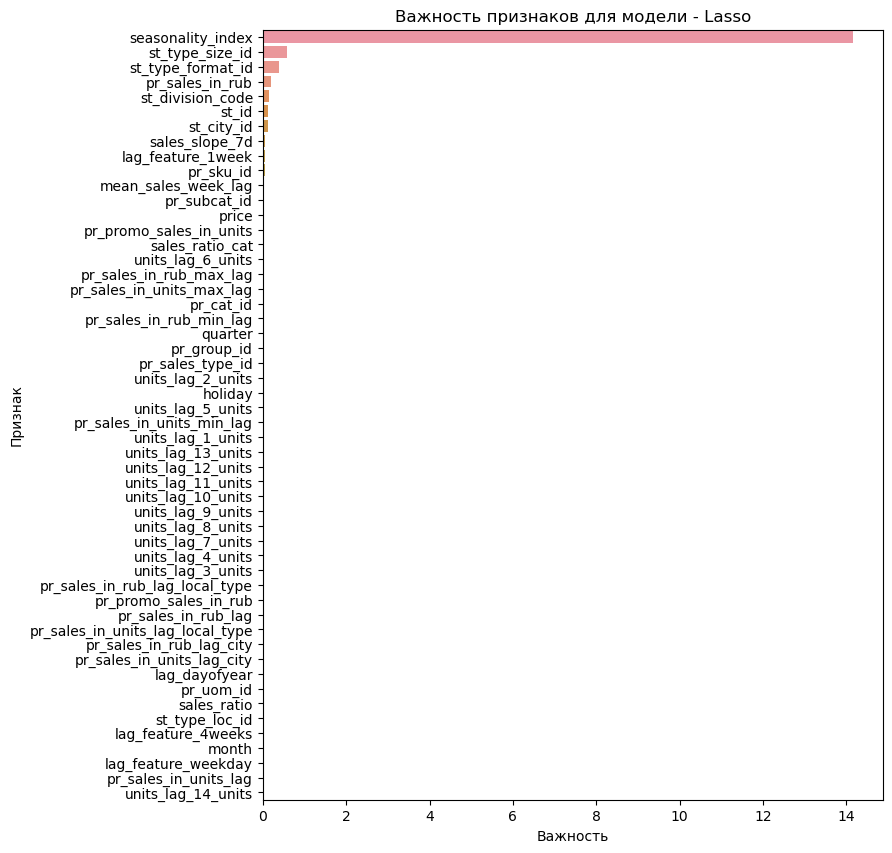

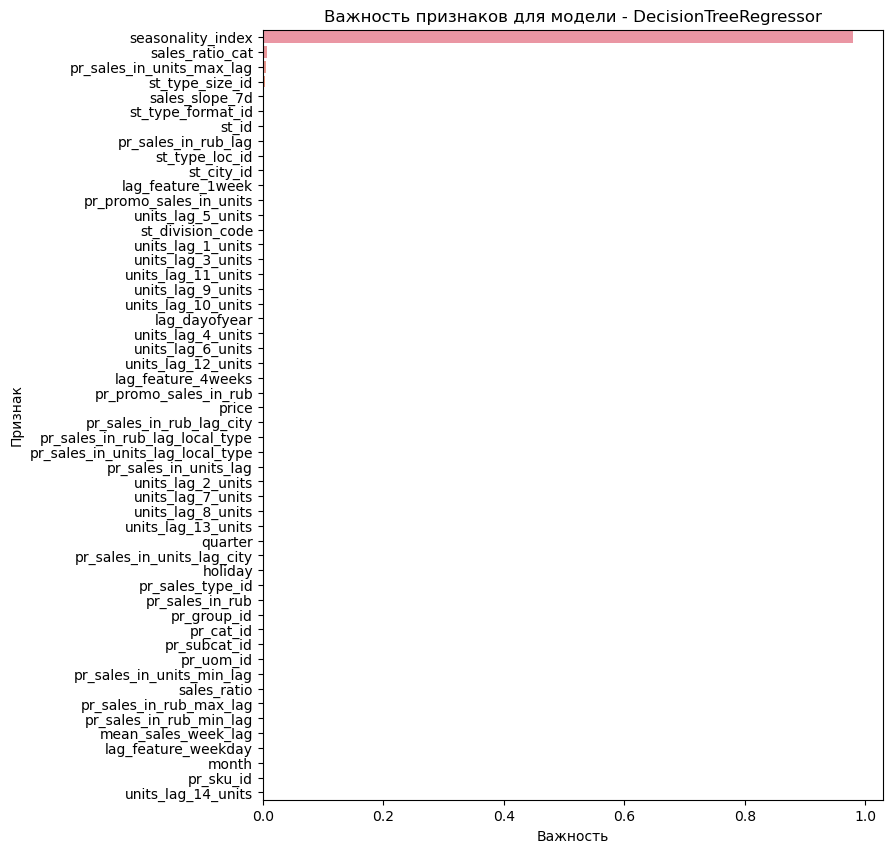

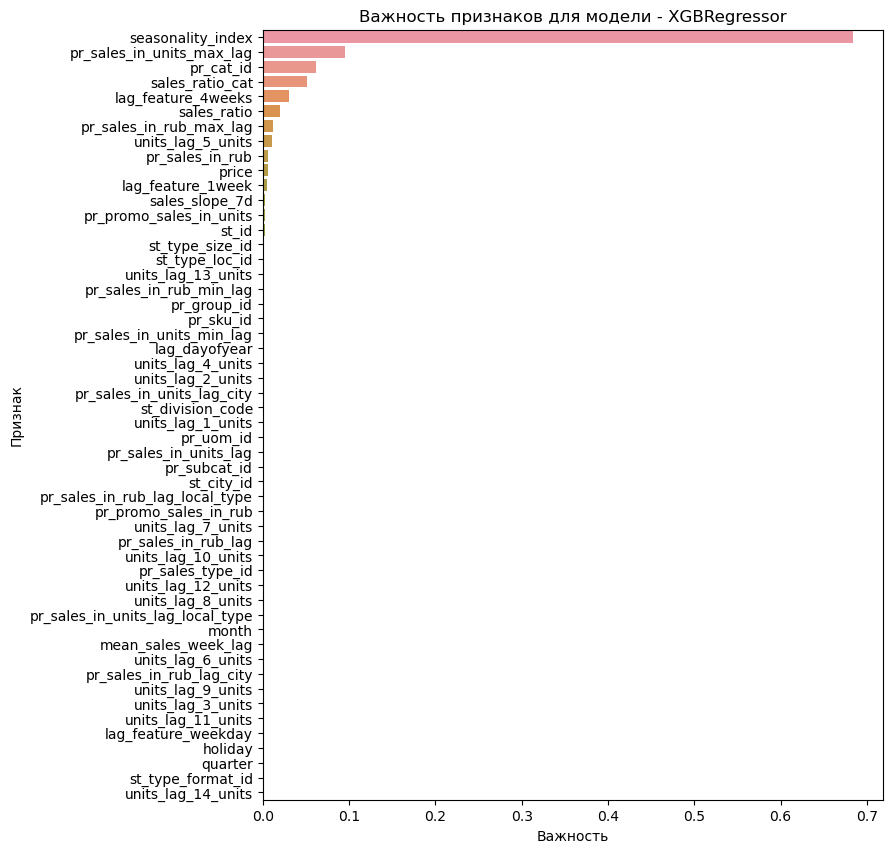

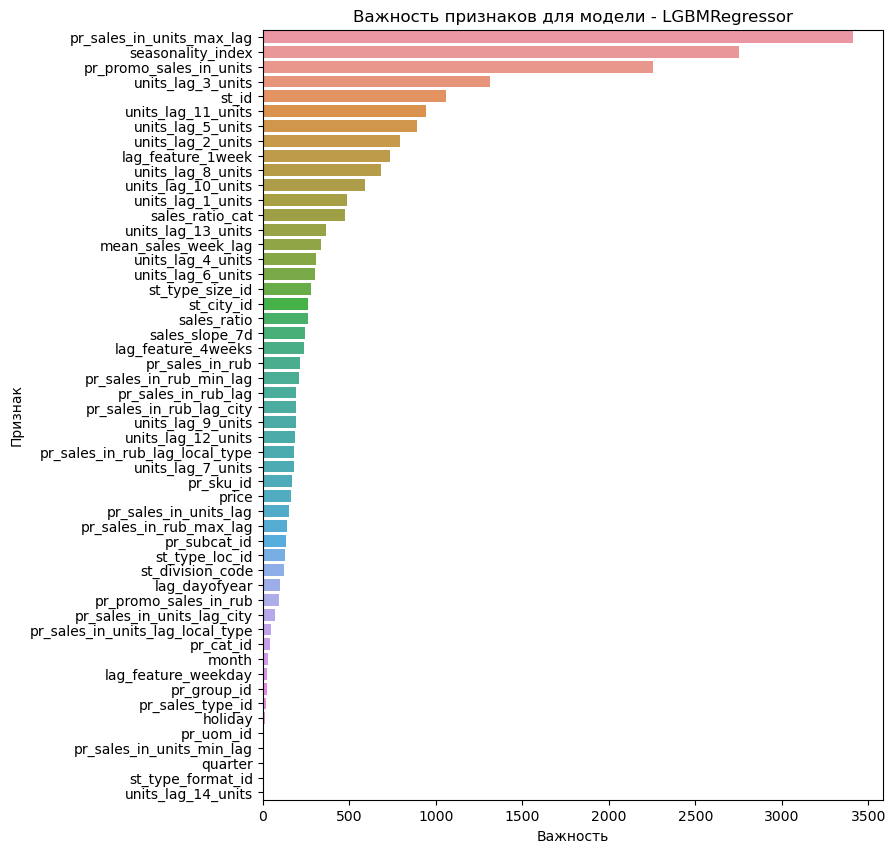

0

In [55]:
feature_importances = []
for pipeline in all_models_units:
    model_name = pipeline.steps[-1][0]
    model = pipeline.steps[-1][1]
    importances = None
    
    if hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_

    feature_importances.append((model_name, importances))
    
    
for model_name, importances in feature_importances:
    if importances is not None:
        importance_df = pd.DataFrame({'Признак': feature_names_units, 'Важность': importances})
        importance_df = importance_df.sort_values(by='Важность', ascending=False)
        plt.figure(figsize=(8, 10))
        sns.barplot(x='Важность', y='Признак', data=importance_df)
        plt.title(f'Важность признаков для модели - {model_name}')
        plt.show()
        
        # Удаление ненужных объектов
    del importance_df
    gc.collect()  
    
# Удаление ненужных объектов
del feature_importances
gc.collect()

**Вывод:**

1. Модель Lasso. Самый важный признак для нее seasonality_index(индекс сезонности). В меньшей степени модель ориентируется на st_type_size_id(тип размера магазина), st_type_format_id(формат магазина), pr_sales_in_rub(общие продажи в рублях), st_id(ID магазина).
2. Модель DecisionTreeRegressor. Самым важным признаком для нее оказался так же индекс сезонности и немного влияния оказывает угловой коэффициент графика продаж товара за последние 14 дней (sales_slope_7d).
3. Модель XGBRegressor. Данная модель для прогнозирования учитывает значительно больше признаков, чем предыдущие модели. Важных признаков можно выделить ТОП 5 наиболее важных признаков: 
     * seasonality_index(индекс сезонности)
     * pr_sales_in_units_max_lag (максисмальная сумма продаж в штуках за 14 дней с группировкой по категориям товаров)
     * pr_cat_id(категория товара)
     * sales_ratio_cat (отношения продаж товара к продажам во всей категории)
     * lag_feature_4weeks (продажи за 4 недели без группировок).
4. Модель LGBMRegressor. Для данной модели можно выделить также ТОП 5 наиболее важных признаков:
     * pr_sales_in_units_max_lag (максисмальная сумма продаж в штуках за 14 дней с группировкой по категориям товаров)
     * seasonality_index(индекс сезонности)
     * pr_promo_sales_in_units(число проданных товаров с признаком промо)
     * units_lag_3_units (количество продаж в штуках за третий день)
     * st_id(ID магазина)
             
В целом самым важным признаком для всех моделей оказался индекс сезонности. Простые модели (Lasso и DecisionTreeRegressor) ориентируется в большей степени на этот признак, а остальные игнорируют. А вот модели градиентного бустнига, помимо индекса сезонности, также учитывают большинство других признаков.

### Тестирование

In [56]:
meta_feat_array_test, target_test_array, features_df_test, target_df_test_u = predict_model_1st_level(test,
                                                                                                      all_models_units,
                                                                                                      'pr_sales_in_units')
meta_predict_test = meta_model_units.predict(meta_feat_array_test)

wape_meta_test = rolling_wape(target_test_array, meta_predict_test)

print('WAPE для мета-модели на тесте:', wape_meta_test)

WAPE для мета-модели на тесте: 0.052185442


**Вывод:**

 Метрики на тестовой выборке с заменненым флагом промо на 0 для всех позиций показала схожую по значению с метриками на валидационной выборке. 

### Сохранение результатов прогнозирования и моделей.

In [57]:
predict_df = pd.DataFrame(meta_predict_test, columns=['predict_sales_in_units'])
predict_df = round(predict_df)
features_df_test.reset_index(inplace= True)

df_predictions = pd.DataFrame({'st_id': features_df_test['st_id'], 
                               'pr_sku_id': features_df_test['pr_sku_id'],
                                'date': features_df_test['date']}) 

# Замена порядковых номеров на исходные значения хэшей
df_predictions['st_id'] = df_predictions['st_id'].map(num_to_hash_dict['st_id'])
df_predictions['pr_sku_id'] = df_predictions['pr_sku_id'].map(num_to_hash_dict['pr_sku_id'])

# Создание датафрейма с исходными значениями и предсказаниями
sales_submission = pd.concat([df_predictions[['st_id', 'pr_sku_id', 'date']], predict_df], axis=1)


sales_submission.to_csv('sales_submission.csv', index=False)

In [58]:
meta_dict = {
    'Lasso': all_models_units[0],
    'DecisionTreeRegressor': all_models_units[1], 
    'XGBRegressor': all_models_units[2],
    'LGBMRegressor': all_models_units[3]
}

In [59]:
# Сохранение моделей
for name, model in meta_dict.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

# Сохранение мета-модели
with open('meta_model_units.pkl', 'wb') as f:
    pickle.dump(meta_model_units, f)
    

### Анализ остатков

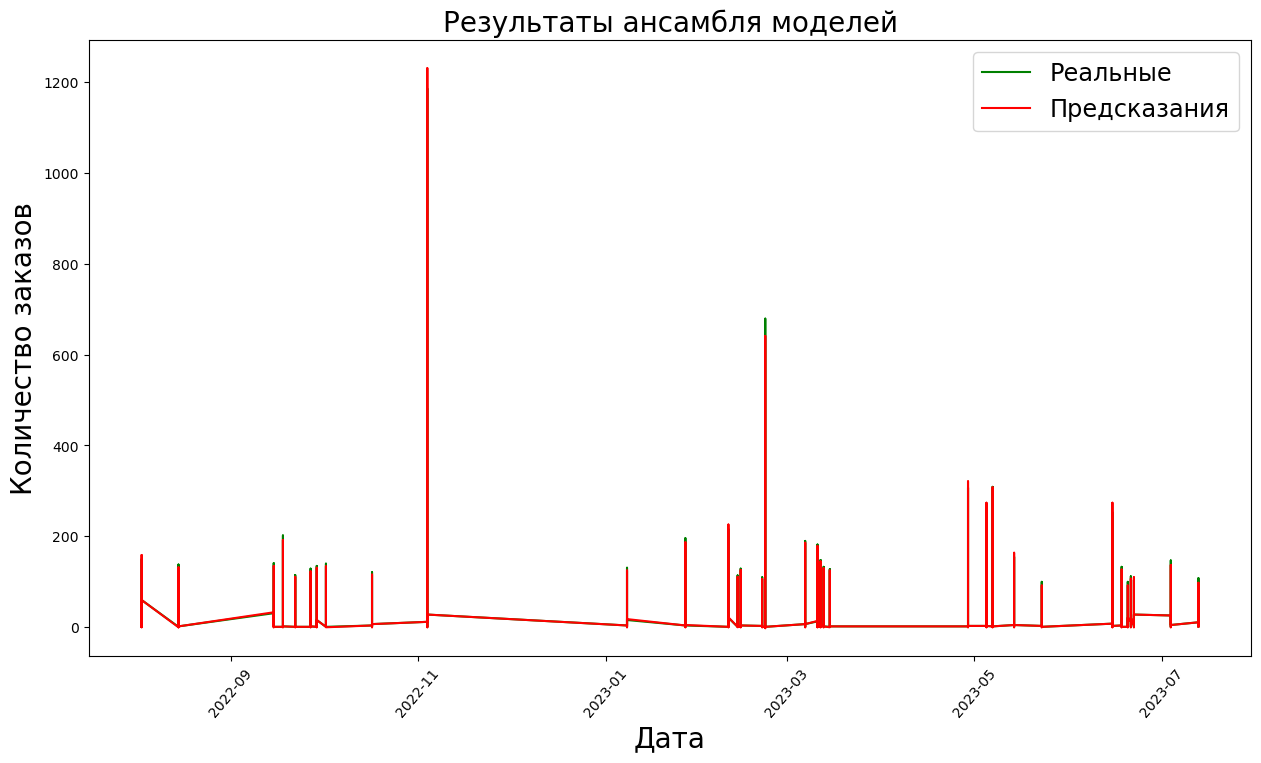

In [60]:
plt.figure(figsize=(15, 8))

plt.plot(target_df_test_u.index, target_df_test_u, 'g-', label='Реальные')
plt.plot(target_df_test_u.index, predict_df['predict_sales_in_units'],'r-', label='Предсказания')

plt.legend(fontsize='xx-large')
plt.title('Результаты ансамбля моделей', fontsize=20)
plt.ylabel('Количество заказов', fontsize=20)
plt.xlabel('Дата', fontsize=20)
plt.xticks(rotation=50)
plt.show()

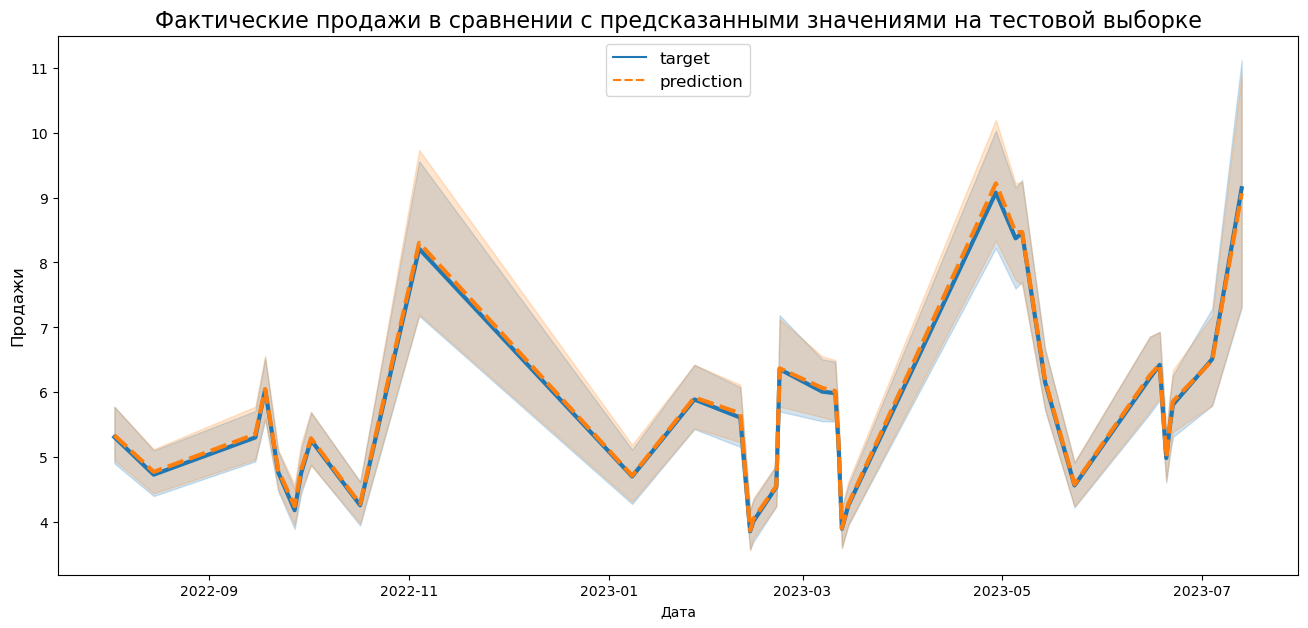

In [61]:
target_df_test_u = target_df_test_u.squeeze()
meta_predict_test = meta_predict_test.squeeze()


# Объединяем истинные значения и предсказания в один DataFrame
df_pred = pd.DataFrame({
    'target': target_df_test_u,
    'prediction': meta_predict_test
})

# Визуализируем результаты
fig, ax = plt.subplots(figsize=(16,7))
sns.lineplot(data=df_pred[['target', 'prediction']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Фактические продажи в сравнении с предсказанными значениями на тестовой выборке', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Продажи', fontsize=12)
plt.show()

Проведем остаточный анализ для прогнозов.

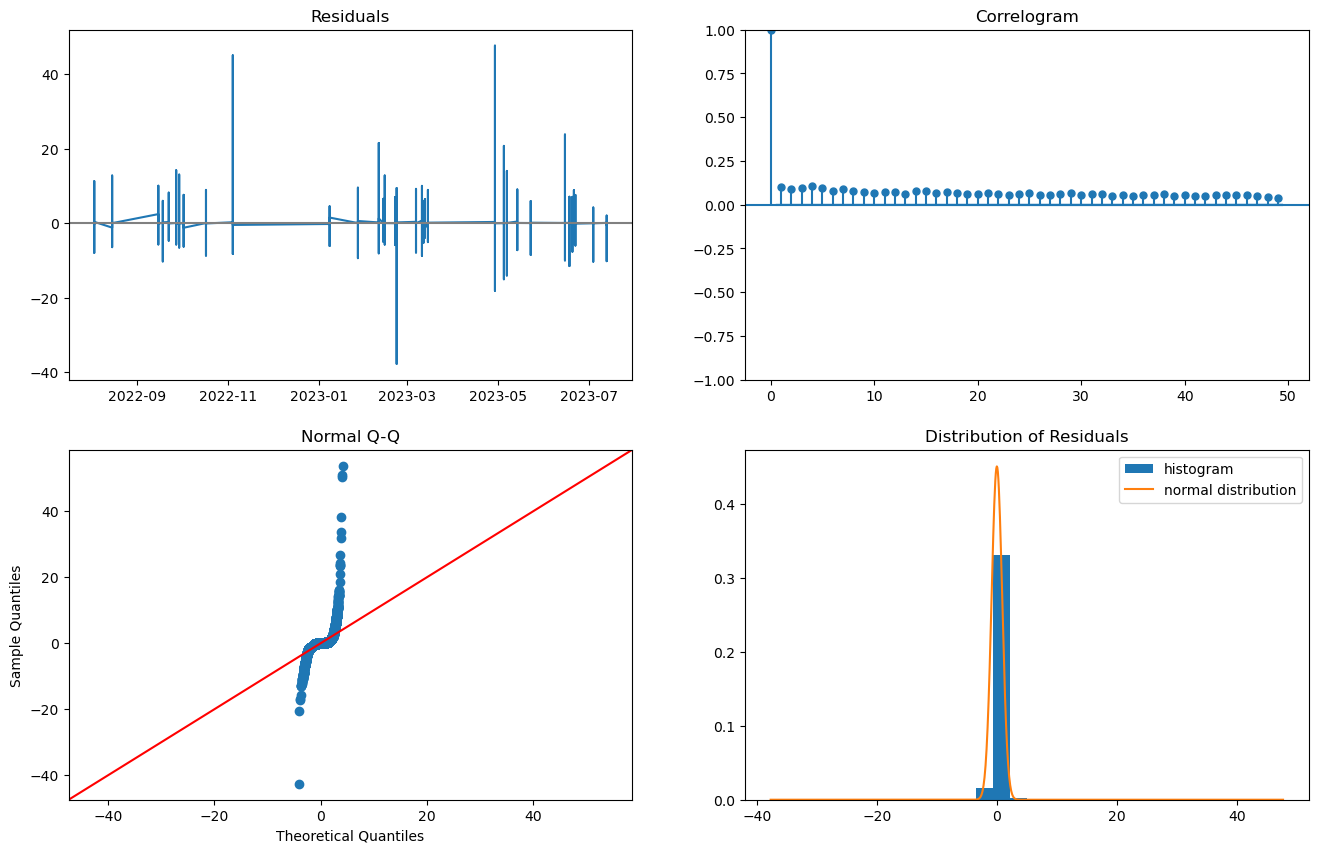

In [62]:
residual_plot(df_pred)

Проведем проверку на адекватность модели. Проверку проведем по сравнению среднего значения.

In [63]:
predicted_mean = np.ones(features_df_test.shape[0])*target_df_test_u.mean()
wape_mean = rolling_wape(target_df_test_u, predicted_mean)
print('WAPE по среднему значению :', wape_mean)

WAPE по среднему значению : 0.9324688366952886


Значение метрики на тесте в сравнении с метрикой по среднему значению  ниже, поэтому можно утвержать, что наша модель адекватна.

# Вывод

### Первичное ознакомление с данными и предобработка


1. Данные изначально были представлены в 3 датафреймах, которые были объединены в единый датафрейм. Итоговый датафрейм содержит 883015 строк и 18 столбцов.
2. Поскольку в некоторых столбцах данные были захэшированы, то был создан словарь хэшов с присвоенными порядковыми номерами для удобства. Столбец date содержит информацию о датах продаж, поэтому был приведен к формату datetime.
3. При первичном ознакомлении с данными пропусков не было обнаружено, но в данных присутствует небольшое количество отрицательных значений. Поскольку нам предоставлены данные о продажах, то отрицательные значения могли возникнуть по нескольким причинами: возврат товар, списание товара или ошибка при выгрузке данных. Такие данные решили исключить из анализа, поскольку количество таких позиций небольшое, а природа происхождения не ясна.


### EDA

**При анализе данных можно выделить следующее:**

1. В нашем распоряжении данные 12 магазинов из 7 городов. Очень мало данных о магазинах с номером 7, 9, 10 и 11. Продажи этих магазинов составляют менее 1% от общего объёма данных.
2. В данных присутствовала информация о товарах с нулевым количество продаж и не нулевой суммой продаж. Эти данные были исключены. А вот данные с нулевыми суммами продаж были заполнены произведением среднего значения цены для каждой позиции товара на количество проданных товаров.
3. В столбце st_is_active представлена о статусе активности магазина в настоящее время. Видно, что в данных присутствует малое количество неактивных магазинов. Их необходимо исключить. И столбец st_is_active можно будет после этого удалить, т.к. не будет нести никакой смысловой информации для нас.
4. Наиболее популярными группами товаров являются группы 1, 0 и 2. Информации о группах товаров 7 и 8 крайне малы, поэтому информация о тех категориях была исключена из дальнейшего анализа.
5. Наиболее популярные категории товаров 4, 3, 0 и 8.


**При изучении информации по каждому магазину в отдельности было выявлено следующее:**


1. У большинства магазинов есть свои уникальные товары, которые продаются, только в их магазине. Исключением из этого являются магазины 2 и 6. В этих магазинах нет уникальных товаров, характерных только для этих магазинов.
2. Магазин с id 10 имеет малое количество продаж. Судя по датам этот магазин относительно недавно открылся. 
3. Магазин с id 7 имеет крайне странные продажи (ровно 1 месяц). Объём таких продаж крайне мал.
4. Магазин с id 11 осуществлял продажи только в период с 24 августа по 8 сентября, при этом сумма продаж составила всего лишь 3498 рублей и продавали всего лишь 2 позиции.
5. Исключили информацию из данных о магазинах с id 7, 11, поскольку информации о продажах данных магазинов была крайне мала и не информативна.


**При изучении информации распределения продаж во времени обнаружено следующее:**


1. В конце декабря, в конце февраля – начале марта, апрель – май имеются высокие всплески количества проданных товаров. Это скорее всего связано с праздниками (Новый год, 23 февраля, 8 марта, масленица, пасха, 1 мая, 9 мая). Самые прибыльные месяца: декабрь, май. Исключение составляет город ID: 6. Для этого города самым прибыльным месяцем оказался июнь.
2. В январе - феврале имеется сильное падение количества продаж. Это объяснимо тем, что люди разъехались за город или закупили достаточно продуктов перед новым годом, а также в целом снижением затрат населения на покупку продуктов после праздников. Месяца с самыми низкими продажами: июль, февраль, январь.
3. Было обнаружено, что товар с категорий 24 продавался только с апреля по июнь и в минимальном количестве. Эту категорию исключили, поскольку данных недостаточно для прогнозирования.
4. Наиболее популярные товары за весь период: 43, 154, 70, 91, 20, 282, 17, 246, 205 и 25
5. Наиболее продаваемые товары города 6 отличается от остальных городов. Возможно, это обусловлено предпочтениями населения в данном городе. Топ-3 самых прибыльных городов:
    * Город ID: 1 - 149 122 692.93
    * Город ID: 0 - 113 512 344.21
    * Город ID: 2 - 106 394 932.08
  
* Самый прибыльный месяц по городам - декабрь. 

**При анализе продаж апреля видно, что наибольшие продажи во всех магазинах приходится на период празднования Пасхи (16 апреля). При рассмотрении продаж товаров по магазинам можно выделить следующее:**
* Больше всего было продано товаров 846, 668, 91, 70 и 43. 
* При изучении информации о продажах за этот месяц по магазинам и городам выявлено, что меньше всего продаж в магазине 10, расположенный в городах 3. 

**При анализе продаж за май выявлено следующее:**
* Суммы продаж в целом распределены равномерно. Но на 9 мая все же приходится чуть больше продаж, чем на остальные недели.
* Топ-5 товаров: 91, 246, 43, 70 и 154.
* Меньше всего продаж приходится на 10 магазин. Также для этого магазина характерен свой топ товаров, который отличается от остальных.



### Feature engineering

Для повышения качества обучения были созданы дополнительные признаки:
* Создан признак о праздничных и выходных днях, т.е. является ли этот день выходным или праздничным.
* Созданы признаки общих продаж, максимальных и минимальных продажами за 14 дней с группировкой  по категориям товаров, городам.
* Также созданы такие признаки как отношения продаж товара к продажам во всей категории, угловой коэффициент графика продаж товара за последние 14 дней, индекс сезонности продаж для каждого магазина


### Обучение моделей

 1. Решения поставленной задачи было принято решение использовать ансамбль моделей. Ансамбль включает в себя 4 модели на первом уровне и 1 модель на втором уровне. 
2. Модели первого уровня:
     * Lasso
     * DecisionTreeRegressor
     * XGBRegressor
     * LGBMRegressor
     
3. Мета-модель: LinearRegressor

4. Качество модели оценивалось по метрике WAPE. Были получены следующие результаты:
   * WAPE для мета-модели продаж на этапе обучения: 0.05557872
   * WAPE для мета-модели на тесте: 0.052185442

### Анализ важности признаков


   В целом самым важным признаком для всех моделей оказался индекс сезонности. Простые модели (Lasso и DecisionTreeRegressor) ориентируется в большей степени на этот признак, а остальные игнорируют. А вот модели градиентного бустнига, помимо индекса сезонности, также учитывают большинство других признаков.
